<div style="text-align:center">
<span style="color:red; font-size:2em; font-weight: bold">Social Media Network Analytics - Assignment 1</span>

## __Name: Harry Marshall__
## __Student ID: s4015845__
## __Github Repo: https://github.com/hd-marshall/NLP-Sentiment-Analysis__
</div>

## __Data Collection__
### Connect to Reddit Client

In [ ]:
# create a reddit client that will gather all the data.
from redditClient import redditClient

# name of subreddit the data is collected from.
subreddit_name= 'stocks'
retrieved_result_limit = 5000

# construct reddit client.
client = redditClient()

# access the subreddit.
subreddit = client.subreddit(subreddit_name)
# print subreddit title.
print(subreddit.title)
# print subreddit descp.
print(subreddit.description)

None


### Amount of Subreddit Submissions in a Month

In [ ]:
# understand the amount of reddit posts made in a month.
import praw
from datetime import datetime, timedelta

# calculate date range.
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=30)
start_timestamp = int(start_date.timestamp())

print(f"Counting posts in r/{subreddit_name} from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# init post count.
post_count = 0

# use 'new' sorting to get posts.
for submission in subreddit.new(limit=None):
    # check if we're within our time range.
    if submission.created_utc < start_timestamp:
        # stop searching after a months worth of posts.
        break
        
    post_count += 1
    
    # print progress every 100 posts.
    if post_count % 100 == 0:
        print(f"Counted {post_count} posts so far...")

# print result.
print(f"\nRESULTS:")
print(f"Total posts in r/{subreddit_name} in the past 30 days: {post_count}")
print(f"Average posts per day: {post_count / 30:.2f}")

### Get and Structure Subreddit Submissions and Comments

In [ ]:
# obtain months worth of reddit posts.
import json
from praw.models import MoreComments
from datetime import datetime
import time

# create a json file name.
output_filename = f'../json/{subreddit_name}-submissions-raw.json'
submissions_json = []

# 750 posts have been made in a month.
for index, submission in enumerate(subreddit.new(limit=retrieved_result_limit)):
    if index % 100 == 0:
        print(f"Collected {index + 1} submissions...")

    submission_data = {
        "submission_id": submission.id,
        "submission_date": submission.created_utc,
        "submission_title": submission.title,
        "submission_author": str(submission.author) if submission.author else "[deleted]",
        "submission_score": submission.score,
        "submission_upvote_ratio": submission.upvote_ratio,
        "submission_num_comments": submission.num_comments,
        "submission_text": submission.selftext if submission.is_self else "",
        # Empty list to hold comments later if needed
        "submission_comments": [] 
    }

    if submission.num_comments > 0:
        comments_list = [comment for comment in submission.comments.list() if not isinstance(comment, MoreComments)]

        for i, comment in enumerate(comments_list):

            if i >= 35:
                break 

            comment_data = {
                "comment_id": comment.id,
                "comment_author": str(comment.author) if comment.author else "[deleted]",
                "comment_score": comment.score,
                "comment_text": comment.body,
                "comment_num_replies": len(comment.replies) if hasattr(comment, "replies") else 0
            }

            submission_data['submission_comments'].append(comment_data)

    submissions_json.append(submission_data)
    time.sleep(0.5)

# final header struct of json file.
final_data = {
    "subreddit": subreddit_name,
    "collection_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "total_posts": len(submissions_json),
    "posts": submissions_json
}

# save to JSON file.
with open(output_filename, 'w', encoding='utf-8') as f:
    json.dump(final_data, f, indent=2, ensure_ascii=False)
    print('json data saved')

## __Exploratory Data Analysis__

### Get the Unique and most Active Users 

In [ ]:
from praw.models import MoreComments
from collections import Counter

# specify which subreddit we are interested in.
subreddit = client.subreddit(subreddit_name)

l_post_author = []
l_comment_author = []

# obtain the hot submissions for this subreddit.
for submission in subreddit.hot(limit=750):
    # print title, but we can print other information of each submission as well.
    if submission.author is not None:
        l_post_author.append(submission.author.name)

    # check submission has comments.
    if submission.num_comments > 0:
        # remove all MoreComments class from list.
        comments_list = [comment for comment in submission.comments.list() if not isinstance(comment, MoreComments)]
        # stop after 35 comments.
        for i, comment in enumerate(comments_list):
            if i >= 35:
                break

            if comment.author is not None:
                l_comment_author.append(comment.author.name)

post_names_counter = Counter(l_post_author)
comment_names_counter = Counter(l_comment_author)

# print the results of post authors.
print(f"Post submission authors: {post_names_counter}")
print(f"Number of Users: {len(post_names_counter)}")

# print the results of comment authors.
print(f"Post submission authors: {comment_names_counter}")
print(f"Number of Users: {len(comment_names_counter)}")

## __Data Preprocessing__

### Text Tokenisation and Stemming

In [5]:
import string
import re
import nltk
nltk.download('stopwords')

def process_text(text):

    # Tweet tokeniser.
    tokenizer = nltk.tokenize.TweetTokenizer()
    l_punct = list(string.punctuation)
    # Add custom stopwords to the standard list
    additional_stopwords = [
        'would', 'could', 'also', 'like', 'one', 'go', 'see', 'think', 'make',
        'get', 'take', 'look', 'know', 'want', 'say', 'said', 'even', 'still',
        'much', 'many', 'back', 'good', 'new', 'this', 'that', 'these', 'those',
        'has', 'had', 'was', 'were', 'been', 'being', 'have', 'any', 'some'
    ]
    stop_words = nltk.corpus.stopwords.words('english') + l_punct + ['via'] + additional_stopwords
    stemmer = nltk.stem.PorterStemmer()

    # Define stock ticker pattern.
    ticker_pattern = r'\$?[A-Z]{2,4}'
    ticker_pattern_2 = r'[A-Z]{1,2}\&[A-Z]{1,2}'

    # Extract potential stock tickers before any processing.
    potential_tickers = set(re.findall(ticker_pattern, text))
    potential_tickers_2 = set(re.findall(ticker_pattern_2, text))
    potential_tickers.update(potential_tickers_2)

    # print known abbreviations. 
    print(potential_tickers)
    
    # convert to lower case, but after extracting tickers.
    text_lower = text.lower()
    
    # get rid of all urls.
    text_lower = re.sub(r'https?://\S+|www\.\S+', '', text_lower)
    
    # filter out emoticons and other noisy characters.
    text_lower = ''.join(char for char in text_lower if char.isalnum() or char.isspace() or char in string.punctuation)
    
    # tokenise text.
    l_tokens = tokenizer.tokenize(text_lower)
    # store original length of text.
    original_word_count = len(l_tokens)
    
    # strip whitespaces.
    l_tokens = [token.strip() for token in l_tokens]
    
    # remove very short tokens and stopwords early, but keep potential stock tickers
    l_tokens = [token for token in l_tokens if 
                (token.upper() in potential_tickers) or
                (len(token) > 2 and  
                token not in stop_words and 
                not token.isdigit() and 
                token != "'" and token != "''" and
                token != "..." and token != "…")]
    
    # now stem only the normal words, but leave stock tickers untouched.
    l_stemmed_tokens = set()
    for tok in l_tokens:
        if tok.upper() in potential_tickers:
            # keep tickers in uppercase to highlight them.
            l_stemmed_tokens.add(tok.upper())
        else:
            # stem regular words.
            l_stemmed_tokens.add(stemmer.stem(tok))
    
    # calc the word count after tokenisation.
    final_word_count = len(l_stemmed_tokens)
    
    # calculate dropped words.
    words_dropped = original_word_count - final_word_count
    return list(l_stemmed_tokens), words_dropped, original_word_count

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harrymarshall/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Save new JSON file with Preprocessed Text
##### Using process_text() function on natural language.

In [6]:
import json
from collections import Counter

# collected submission json file.
input_filename = f'../datasets/{subreddit_name}-submissions-raw.json'
output_filename = f'../datasets/{subreddit_name}-submissions-token.json'

# number of most frequent terms to display.
freq_num = 85

# term freq counter.
term_freq_counter = Counter()

# attributes in the json struct that need to be tokenised.
tokenised_submission = [
    'submission_title',
    'submission_text',
]

total_words_dropped = 0
total_words_dataset = 0

# open JSON file and process submissions.
with open(input_filename, 'r', encoding='utf-8') as f:
    d_submissions = json.load(f)

    for submission in d_submissions['posts']:

        for var in tokenised_submission:
            submission_text = submission.get(var, '')
            l_tokens, submission_words_dropped, submission_words = process_text(submission_text)
            # replace original text with tokenized version.
            submission[var] = ' '.join(l_tokens)
            term_freq_counter.update(l_tokens)

            total_words_dropped += submission_words_dropped
            total_words_dataset += submission_words

        for comment in submission['submission_comments']:
            comment_text = comment.get('comment_text', '')
            l_tokens, comment_words_dropped, comment_words = process_text(comment_text)
            # replace original text with tokenized version.
            comment['comment_text'] = ' '.join(l_tokens)

            term_freq_counter.update(l_tokens)

            total_words_dropped += comment_words_dropped
            total_words_dataset += comment_words

# save the tokenised data to a new JSON file.
with open(output_filename, 'w', encoding='utf-8') as f:
    json.dump(d_submissions, f, ensure_ascii=False, indent=2)

print(f"Amount of words in text fields: {total_words_dataset}")
print(f"Amount of words dropped: {total_words_dropped}")
# print out most common terms.
ranking = 1
for term, count in term_freq_counter.most_common(freq_num):
    print(str(ranking) + ': ' + term + ': ' + str(count))
    ranking += 1

set()
{'RFK', 'DJT', 'JNJ', 'IPO', 'FDA', 'LYV', 'NMAX', 'MRNA', 'THIR', 'NVAX', 'US'}
set()
{'TA', 'MACD', 'VWAP', 'ATR', 'RSI'}
set()
{'DOGE', 'AI', 'DELL'}
{'IPO'}
{'NVDA', 'TXN', 'TSMC', 'MCHP', 'MU', 'MRVL', 'QCOM', 'US', 'TSM', 'AMD'}
set()
set()
set()
{'JPM', 'MOC'}
set()
set()
set()
set()
{'$CELH'}
set()
{'NMAX'}
{'IT', 'NT', 'IPO'}
{'DS', 'VAL'}
{'BSX'}
{'AAPL'}
{'SCHG', 'VOO', 'SP', 'QQQ'}
set()
set()
set()
set()
{'S&P', 'RIP'}
set()
{'IBM'}
{'DJT'}
set()
set()
set()
set()
set()
set()
set()
set()
{'LSEG'}
set()
{'US', 'EU', 'AM'}
{'FUD'}
set()
{'US', 'EU'}
{'US'}
{'SP', 'ED', 'UD', 'IT', 'ALK', 'FUD'}
{'OR', 'ATH'}
{'SP', 'US'}
{'US', 'EU'}
set()
set()
{'EV', 'SZ', 'PFA', 'BYD'}
set()
{'TSLA'}
set()
{'TSLA'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'BYD'}
set()
set()
set()
set()
set()
set()
set()
{'BYD'}
{'USD', 'CNY', 'BYD'}
set()
set()
set()
set()
set()
set()
{'YOUR'}
set()
set()
{'ETF'}
set()
set()
set()
set()
set()
set()
set()
{'VUSX', 'SE', 'MSF

### Plot Most Frequent Words

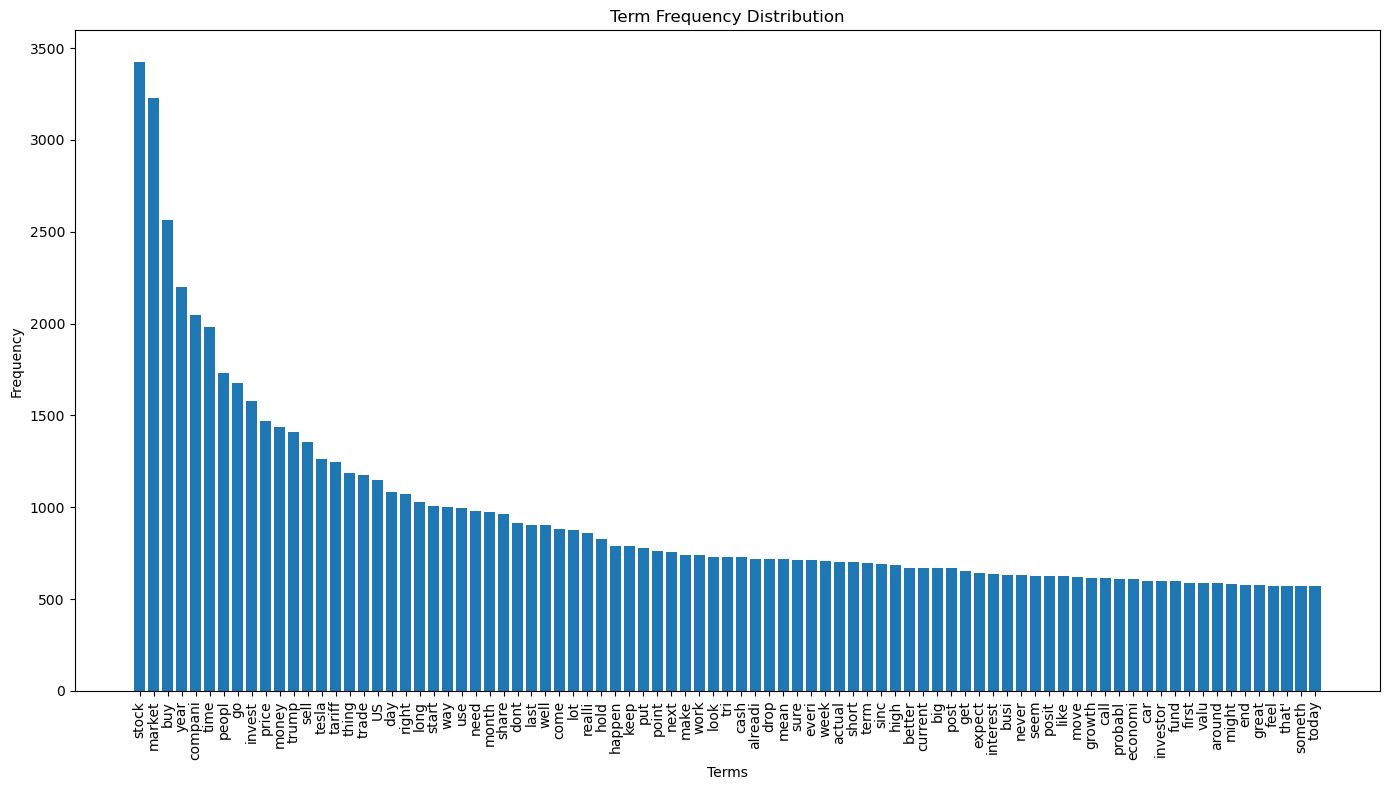

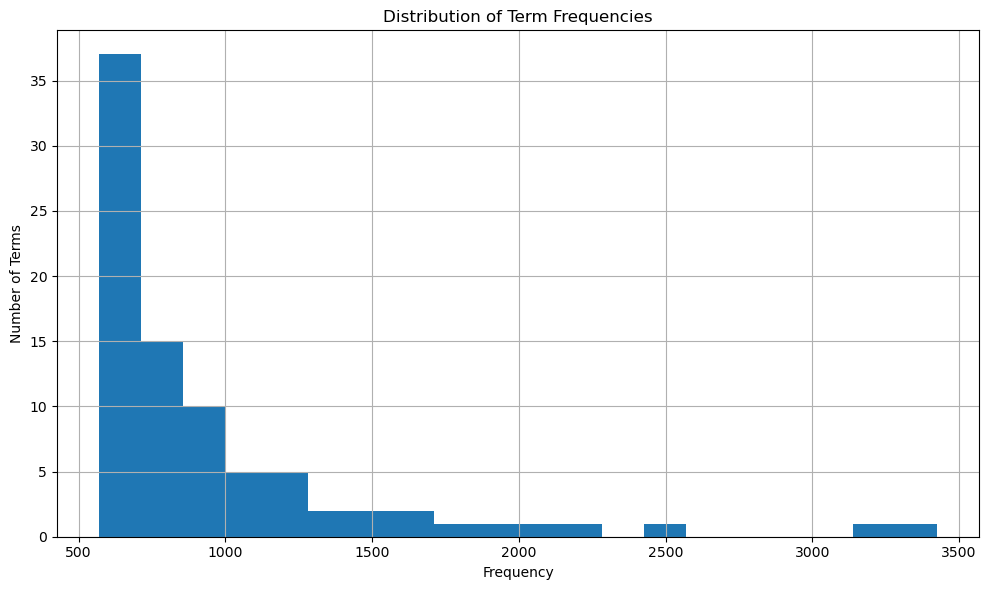

In [7]:
import matplotlib.pyplot as plt

# get the most common terms,
most_common = term_freq_counter.most_common(freq_num)

# create histogram of term frequencies.
terms, counts = zip(*most_common)

# create a bar chart.
plt.figure(figsize=(14, 8))
plt.bar(range(len(terms)), counts, align='center')
plt.xticks(range(len(terms)), terms, rotation=90)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Term Frequency Distribution')
plt.tight_layout()
plt.show()

# create a histogram of frequency values to show the distribution pattern.
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=20)
plt.xlabel('Frequency')
plt.ylabel('Number of Terms')
plt.title('Distribution of Term Frequencies')
plt.grid(True)
plt.tight_layout()
plt.show()

##  __Method and Modelling__

### Load Sentiment Analysis and Slang Words

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

custom_lexicon = {
    # postive terms.
    'moon': 3.0,
    'mooning': 3.0,
    'bull': 2.0,
    'bullish': 2.5,
    'long': 1.0,
    'calls': 1.5,
    'hodl': 1.0,
    'tendies': 2.0,
    'rocket': 2.5,
    'rocketship': 2.5,
    'yolo': 1.5,
    'buy the dip': 1.5,
    'btd': 1.5,
    'ath': 2.0,
    'breakout': 1.5,
    'outperform': 1.5,
    'upgrade': 1.0,
    'beat': 1.0,
    
    # negative terms.
    'bear': -2.0,
    'bearish': -2.5,
    'short': -1.0,
    'puts': -1.5, 
    'bagholder': -2.0,
    'sell off': -1.5,
    'dump': -2.0,
    'crash': -3.0,
    'recession': -2.5,
    'drilling': -2.0,
    'tanking': -2.5,
    'guh': -2.0,
    'rugpull': -3.0,
    'fud': -1.5,
    'underperform': -1.5,
    'downgrade': -1.0,
    'miss': -1.0,
}
    

stemmed_lexicon = {}
for word, score in custom_lexicon.items():
    stemmed_tokens, _, _ = process_text(word)
    
    # join into a string if there are tokens
    if stemmed_tokens:
        stemmed_word = ' '.join(stemmed_tokens)
        stemmed_lexicon[stemmed_word] = score

# start VADER sentiment analyser.
sia = SentimentIntensityAnalyzer()

# update VADER's lexicon with our stemmed custom lexicon.
sia.lexicon.update(stemmed_lexicon)

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/harrymarshall/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Compute Sentiment Function

In [9]:
def compute_sentiment(l_tokens):
    
    return sia.polarity_scores(l_tokens)

### Average Sentiment Analysis of Submissions

In [10]:
import json
import datetime

# import tokenised submission JSON file.
input_filename = f'../datasets/{subreddit_name}-submissions-token.json'
output_json = f'../datasets/{subreddit_name}-submissions-tf-idf.json'
output_csv = f'../datasets/{subreddit_name}-submissions-tf-idf.csv'

# variables for text fields.
tokenised_submission = [
    'submission_title',
    'submission_text',
]

# dictionary to store submission data.
submission_texts = {}
submission_metadata = {}
submission_topics = {}
all_topics = set()

# open JSON file and process submissions.
with open(input_filename, 'r', encoding='utf-8') as f:
    d_submissions = json.load(f)
    
    # extract text from each submission and its comments.
    for submission in d_submissions['posts']:
        submission_id = submission.get('submission_id', '')
        combined_text = ""
        sentiment_total = 0
        num_sentiment_items = 0
        
        # get timestamp information.
        created_utc = submission.get('submission_date', '')
        if created_utc:
            try:
                date_time = datetime.datetime.fromtimestamp(float(created_utc))
            except:
                date_time = None
        else:
            date_time = None
        
        # get submission text fields.
        for var in tokenised_submission:
            submission_text = submission.get(var, '')
            if submission_text:
                sentiment_score = compute_sentiment(submission_text)
                print(sentiment_score['compound'])
                sentiment_total += sentiment_score['compound']
                num_sentiment_items += 1
                combined_text += " " + submission_text
        
        # get comment text fields.
        for comment in submission.get('submission_comments', []):
            comment_text = comment.get('comment_text', '')
            if comment_text:
                sentiment_score = compute_sentiment(comment_text)  # Changed from combined_sentiment to compute_sentiment
                sentiment_total += sentiment_score['compound']
                num_sentiment_items += 1
                combined_text += " " + comment_text
        
        # calculate average sentiment.
        avg_sentiment = sentiment_total / num_sentiment_items if num_sentiment_items > 0 else 0
        
        # store the combined text and metadata for this submission.
        submission_texts[submission_id] = combined_text.strip()
        submission_metadata[submission_id] = {
            'date': date_time.strftime('%Y-%m-%d') if date_time else '',
            'time': date_time.strftime('%H:%M:%S') if date_time else '',
            'timestamp': date_time.timestamp() if date_time else None,
            'sentiment': avg_sentiment,
            'num_comments': len(submission.get('submission_comments', [])),
            'topics': []  # Will be filled after TOPIC analysis.
        }

0.4588
-0.9371
0.0
0.9169
-0.5423
-0.7351
-0.5719
-0.2263
0.5423
0.875
0.2263
0.91
-0.7351
-0.5267
0.0
-0.1779
-0.6249
0.875
-0.6739
-0.25
0.296
-0.3818
0.0
0.2263
-0.2732
-0.5574
0.0
0.3612
-0.6705
-0.9382
0.6124
-0.5859
0.0
-0.25
0.0
0.9001
0.0
0.8271
-0.25
-0.128
0.0
0.3818
-0.2732
0.1335
0.0
0.25
0.0
-0.3612
0.0
0.0
0.4588
-0.6808
0.0
0.6249
0.0
0.5994
0.2263
-0.0736
0.6369
0.0516
-0.5423
-0.3818
0.0
-0.8402
0.0
-0.34
0.0
0.8807
0.0
-0.0516
-0.296
0.6486
0.0
0.3087
0.0
0.9571
0.0
0.516
0.0
0.936
0.4019
0.8727
0.0
0.0
0.0
-0.4472
0.4417
0.3818
-0.5423
0.4767
0.0
0.8885
0.0
0.9432
0.235
0.7115
-0.25
0.7184
-0.3612
0.8209
0.2023
-0.0772
0.2732
0.4588
0.0
-0.4215
0.0
0.4588
0.0
0.3111
0.0
0.5423
0.0
0.872
0.0
0.5994
0.0
-0.851
0.0
0.128
-0.6249
0.6597
-0.3612
0.2732
0.3818
-0.34
0.0
0.8834
0.0
0.7816
0.0
-0.896
0.0
-0.7783
0.0
-0.2023
0.0
0.4215
0.0772
0.6378
0.3818
0.3818
0.0
-0.1779
0.0
0.802
0.0
0.8426
0.0
0.3612
0.0
-0.6369
0.296
0.296
-0.4767
-0.4082
0.296
0.7695
0.0
0.9656
0.6249

### TF-IDF (Term Frequency-Inverse Document Frequency) Topic Analysis

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create corpus from all submission texts.
corpus = list(submission_texts.values())
submission_ids = list(submission_texts.keys())

# create TF-IDF. 
tfidf_vectorizer = TfidfVectorizer(
    # >80% of documents.
    max_df=0.8,  
    # min doc word count. 
    min_df=3,
    # top 500 features.
    max_features=500,
    # ignore single words or phrases.
    ngram_range=(1, 2)
)

# fit the vectorizer to the corpus.
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# get feature names.
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")

# get top terms for each submission based on TF-IDF scores.
for i, submission_id in enumerate(submission_ids):
    # get the document vector.
    doc_vector = tfidf_matrix[i].toarray()[0]
    
    # get indices of top 10 TF-IDF scores.
    top_indices = doc_vector.argsort()[-10:][::-1]
    
    # get corresponding terms and their scores.
    top_terms_with_scores = [(feature_names[idx], doc_vector[idx]) for idx in top_indices if doc_vector[idx] > 0]
    top_terms = [term for term, score in top_terms_with_scores]

    # store as the topic for this submission
    submission_topics[submission_id] = top_terms
    # update metadata
    submission_metadata[submission_id]['topics'] = top_terms
    
    # add to overall set of topics
    all_topics.update(top_terms)

Number of features: 500


### UniGrams and BiGrams

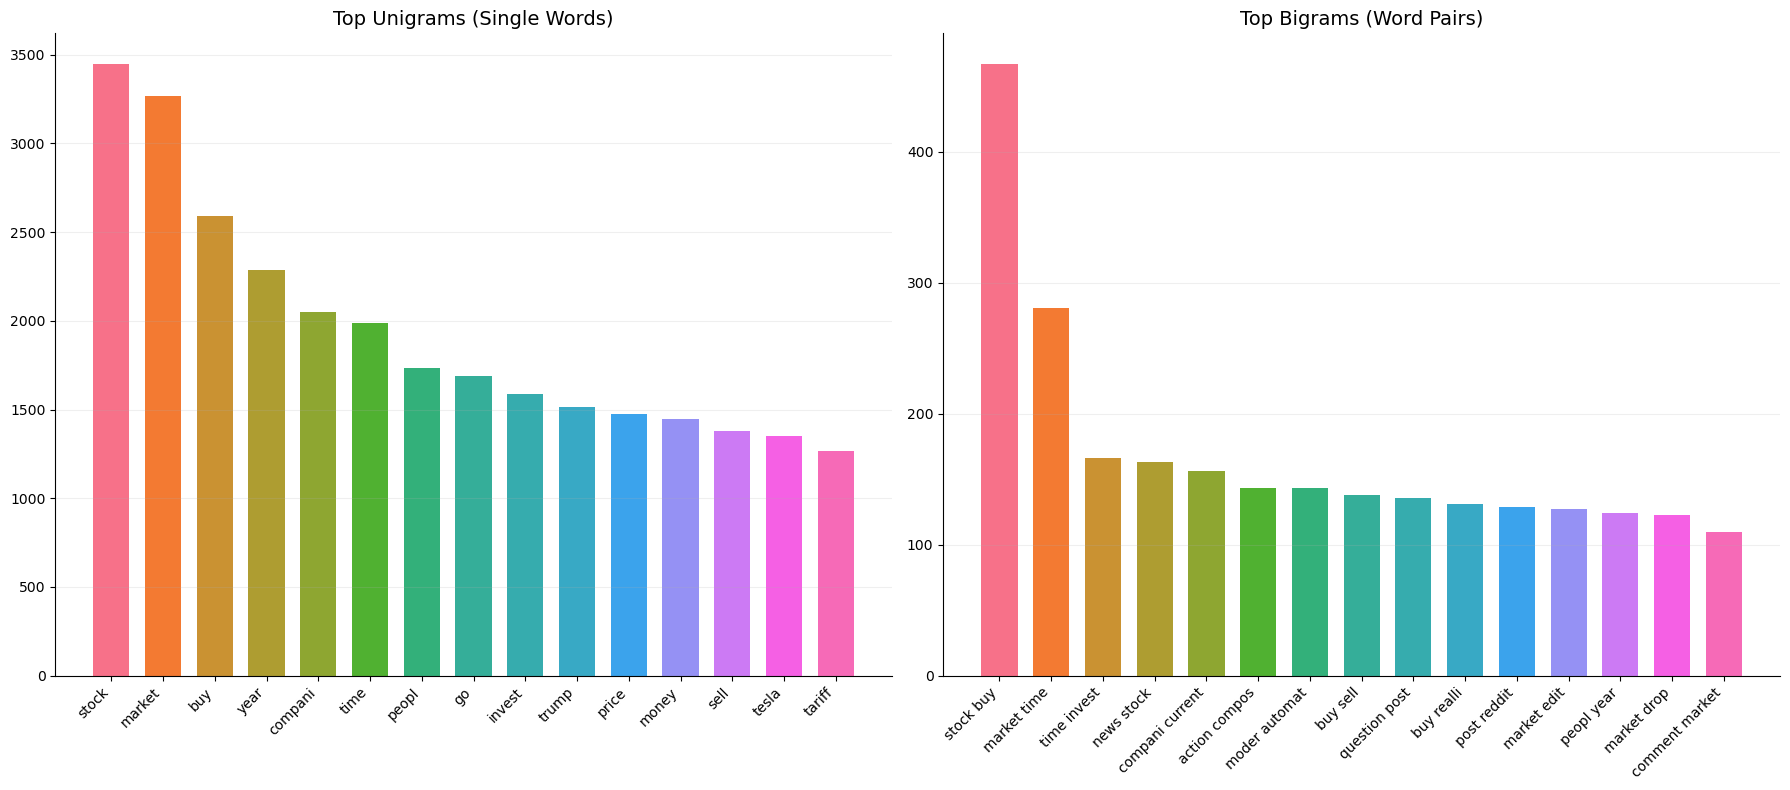

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create corpus from all submission texts
corpus = list(submission_texts.values())
submission_ids = list(submission_texts.keys())

# Create a document-term matrix using CountVectorizer
count_vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=1,
    max_features=1000,
    ngram_range=(1, 2) # include unigrams and bigrams
)
# Fit the vectorizer to the corpus
doc_term_matrix = count_vectorizer.fit_transform(corpus)
feature_names = count_vectorizer.get_feature_names_out()

# Extract unigrams and bigrams
unigram_indices = [i for i, feature in enumerate(feature_names) if ' ' not in feature]
bigram_indices = [i for i, feature in enumerate(feature_names) if ' ' in feature]

# Get unigram frequencies
unigram_names = [feature_names[i] for i in unigram_indices]
unigram_counts = doc_term_matrix[:, unigram_indices].sum(axis=0).A1
unigram_freq = dict(zip(unigram_names, unigram_counts))
sorted_unigrams = sorted(unigram_freq.items(), key=lambda x: x[1], reverse=True)
# Get bigram frequencies
bigram_names = [feature_names[i] for i in bigram_indices]
bigram_counts = doc_term_matrix[:, bigram_indices].sum(axis=0).A1
bigram_freq = dict(zip(bigram_names, bigram_counts))
sorted_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

# Create a side-by-side visualization of unigrams and bigrams
def plot_unigrams_and_bigrams(sorted_unigrams, sorted_bigrams, n=15):
    """Create side-by-side plots of top unigrams and bigrams."""
    # Get actual number to plot
    n_unigrams = min(n, len(sorted_unigrams))
    n_bigrams = min(n, len(sorted_bigrams))
    
    if n_bigrams == 0:
        print("No bigrams to visualize!")
        return
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Get colorful palettes for bars
    colors1 = sns.color_palette("husl", n_unigrams)
    colors2 = sns.color_palette("husl", n_bigrams)
    
    # Plot unigrams
    u_data = sorted_unigrams[:n_unigrams]
    unigrams, u_counts = zip(*u_data)
    bars1 = ax1.bar(range(n_unigrams), u_counts, width=0.7, color=colors1, edgecolor='none')
    ax1.set_title('Top Unigrams (Single Words)', fontsize=14)
    ax1.set_xticks(range(n_unigrams))
    ax1.set_xticklabels(unigrams, rotation=45, ha='right', fontsize=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(axis='y', linestyle='-', alpha=0.2)
    
    # Plot bigrams
    b_data = sorted_bigrams[:n_bigrams]
    bigrams, b_counts = zip(*b_data)
    bars2 = ax2.bar(range(n_bigrams), b_counts, width=0.7, color=colors2, edgecolor='none')
    ax2.set_title(f'Top Bigrams (Word Pairs)', fontsize=14)
    ax2.set_xticks(range(n_bigrams))
    ax2.set_xticklabels(bigrams, rotation=45, ha='right', fontsize=10)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.grid(axis='y', linestyle='-', alpha=0.2)
    
    plt.tight_layout()
    plt.show()

# Plot unigrams and bigrams side by side
plot_unigrams_and_bigrams(sorted_unigrams, sorted_bigrams, n=15)

### LDA Topic Analysis

In [13]:
# Set the number of topics for LDA
num_topics = 15
# Create and fit the LDA model
lda_model = LatentDirichletAllocation(
    n_components=num_topics,
    max_iter=10,
    learning_method='online',
    random_state=42,
    batch_size=128,
    learning_decay=0.7
)
# Fit the model to the document-term matrix
lda_model.fit(doc_term_matrix)
# Function to print top words for each topic
def print_top_words(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_terms = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(topic_terms)
        print(f"Topic #{topic_idx+1}: {', '.join(topic_terms)}")
    return topics
# Print top words for each topic
print("\nTopics found by LDA:")
all_topics_list = print_top_words(lda_model, feature_names)
# Get topic distribution for each document
topic_distributions = lda_model.transform(doc_term_matrix)
# Assign the most probable topic to each submission
submission_topics = {}
all_topics = set()
for i, submission_id in enumerate(submission_ids):
    # Get the most probable topic for this document
    dominant_topic_idx = np.argmax(topic_distributions[i])
    # Get the top terms for this topic
    top_terms = all_topics_list[dominant_topic_idx]
    # Store as the topic for this submission
    submission_topics[submission_id] = top_terms
    # Update metadata (if submission_metadata exists)
    if 'submission_metadata' in globals():
        submission_metadata[submission_id]['topics'] = top_terms
    # Add top terms to overall set of topics
    all_topics.update(top_terms)
# Count the frequency of topics across all submissions
topic_counts = {}
for topics in submission_topics.values():
    for topic in topics:
        if topic in topic_counts:
            topic_counts[topic] += 1
        else:
            topic_counts[topic] = 1
# Print the most common topics
print("\nMost Common Topics:")
for topic, count in sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"{topic}: {count}")


Topics found by LDA:
Topic #1: reuter, finviz, aggreg, stock, portfolio, sticki, pleas, includ, question, check
Topic #2: return, brk, total, prefer, stock, use, day, exampl, end, two
Topic #3: reddit, stock, time, way, peopl, year, invest, go, googl, right
Topic #4: walmart, target, store, retail, consum, amazon, year, dollar, low, peopl
Topic #5: buy, stock, market, time, day, price, year, trade, sell, go
Topic #6: us, trump, tariff, countri, american, european, europ, canada, defens, eu
Topic #7: compani, ai, year, use, stock, googl, revenu, growth, time, busi
Topic #8: tesla, car, elon, musk, compani, tsla, stock, ev, sale, buy
Topic #9: stock, peopl, compani, buy, price, reddit, market, money, share, use
Topic #10: trump, tariff, market, stock, sure, everyon, interest, action, without, affect
Topic #11: market, tariff, trump, economi, recess, go, rate, inflat, cut, year
Topic #12: tariff, car, buy, market, price, stock, american, year, peopl, share
Topic #13: liber, april, sell, 

### Topic Focused Data Structure

In [14]:
# create a topic-oriented view.
topic_analysis = {}
for topic in all_topics:
    # find all submissions containing this topic.
    relevant_submissions = [
        sub_id for sub_id, topics in submission_topics.items() 
        if topic in topics
    ]
    
    # calculate average sentiment for this topic.
    sentiments = [submission_metadata[sub_id]['sentiment'] for sub_id in relevant_submissions if submission_metadata[sub_id]['sentiment'] != 0]
    avg_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
    
    # get timestamps for temporal analysis.
    timestamps = [submission_metadata[sub_id]['timestamp'] for sub_id in relevant_submissions 
                 if submission_metadata[sub_id]['timestamp'] is not None]
    
    # store topic data.
    topic_analysis[topic] = {
        'count': len(relevant_submissions),
        'avg_sentiment': avg_sentiment,
        'submissions': relevant_submissions,
        'earliest_mention': min(timestamps) if timestamps else None,
        'latest_mention': max(timestamps) if timestamps else None
    }

### No. of Topics

In [15]:
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# create a DataFrame for easier analysis and graphing.
rows = []
for submission_id, metadata in submission_metadata.items():
    for topic in metadata['topics']:
        rows.append({
            'submission_id': submission_id,
            'date': metadata['date'],
            'time': metadata['time'],
            'timestamp': metadata['timestamp'],
            'sentiment': metadata['sentiment'],
            'num_comments': metadata['num_comments'],
            'topic': topic
        })

df = pd.DataFrame(rows)

# save the DataFrame for later visualisation.
df.to_csv(output_csv, index=False)

# save the full analysis results to JSON.
results = {
    'submission_metadata': submission_metadata,
    'submission_topics': submission_topics,
    'topic_analysis': {k: v for k, v in topic_analysis.items() if k},
    'all_topics': list(all_topics)
}

print(f"Found {len(all_topics)} unique topics across {len(submission_texts)} submissions")

Found 82 unique topics across 855 submissions


### Display Most Common Topics Frequency

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


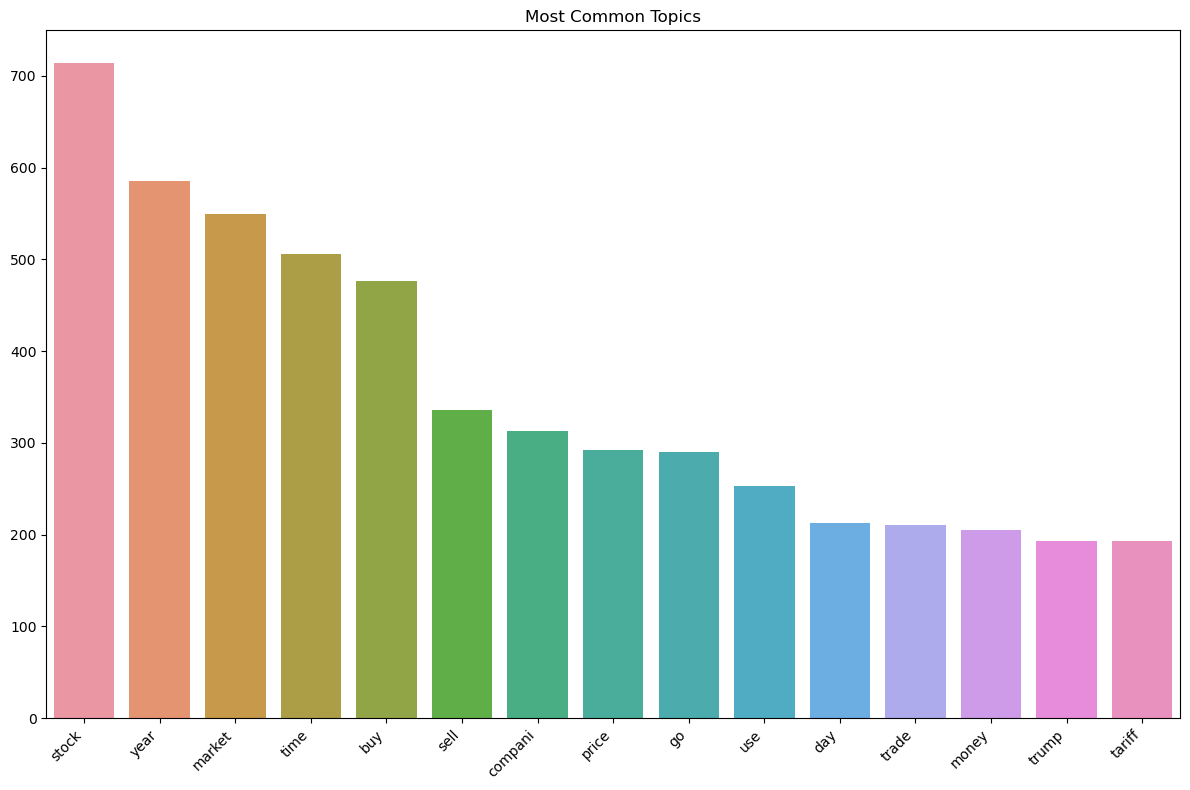

In [16]:
# 1. most common topics
topic_counts = Counter([topic for topics_list in submission_topics.values() for topic in topics_list])
top_topics = topic_counts.most_common(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=[topic for topic, _ in top_topics], y=[count for _, count in top_topics])
plt.title('Most Common Topics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_topics.png')

### Display Most Common Topics Sentiment Distributions

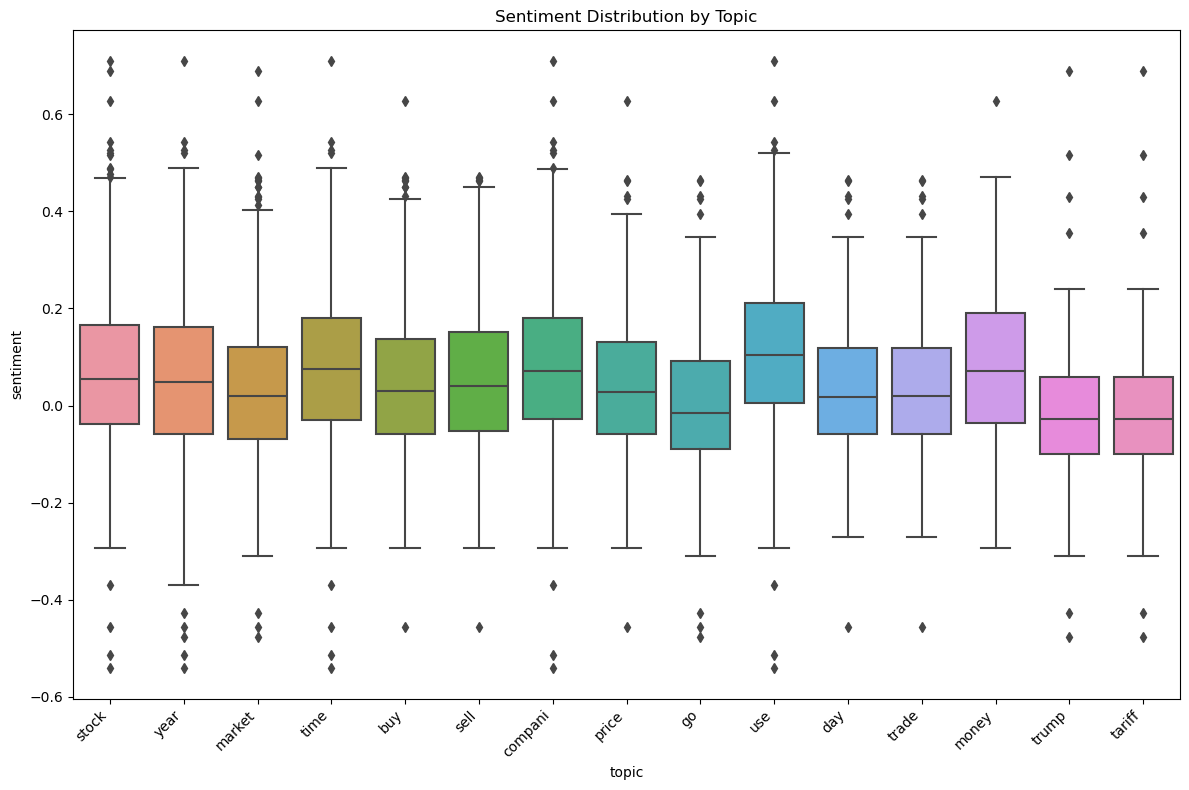

In [17]:
# 2. sentiment distribution by top topics
top_topic_names = [topic for topic, _ in top_topics[:15]]
topic_sentiments = df[df['topic'].isin(top_topic_names)]
# get topics in order of frequency
ordered_topics = [topic for topic, _ in top_topics[:15]]

# Use this order in the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='topic', y='sentiment', data=topic_sentiments, order=ordered_topics)
plt.title('Sentiment Distribution by Topic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('topic_sentiments.png')

### Most Common Topics Highest and Lowest Rated Submissions

In [18]:
# 3. Print min and max sentiment submission IDs for top 5 topics
print("\n--- Min/Max Sentiment Submission IDs for Top 5 Topics ---")
for topic, count in top_topics[:25]:
    print(f"\nTopic: {topic} (Count: {count})")
    # Get relevant submissions and their sentiment scores
    topic_submissions = []
    for sub_id in topic_analysis[topic]['submissions']:
        sentiment = submission_metadata[sub_id]['sentiment']
        date = submission_metadata[sub_id]['date']
        topic_submissions.append((sub_id, sentiment, date))
    
    # Skip if no submissions with valid sentiment scores
    if not topic_submissions:
        print(" No submissions with sentiment scores found")
        continue
    
    # Find min and max sentiment submissions
    min_submission = min(topic_submissions, key=lambda x: x[1])
    max_submission = max(topic_submissions, key=lambda x: x[1])
    
    # Print min sentiment submission
    print(f" Minimum Sentiment:")
    print(f" Submission ID: {min_submission[0]}")
    print(f" Sentiment Score: {min_submission[1]:.4f}")
    print(f" Date: {min_submission[2]}")
    
    # Print max sentiment submission
    print(f" Maximum Sentiment:")
    print(f" Submission ID: {max_submission[0]}")
    print(f" Sentiment Score: {max_submission[1]:.4f}")
    print(f" Date: {max_submission[2]}")
    
    # Create sentiment trend graph
    # Instead of filtering the DataFrame by topic (which doesn't exist),
    # Create a new DataFrame for this specific topic using the submission data
    
    # Get all submission IDs for this topic with their timestamps and sentiment scores
    topic_data = []
    for sub_id in topic_analysis[topic]['submissions']:
        if sub_id in submission_metadata:
            timestamp = submission_metadata[sub_id].get('timestamp')
            sentiment = submission_metadata[sub_id].get('sentiment')
            if timestamp is not None and sentiment is not None:
                topic_data.append({
                    'submission_id': sub_id,
                    'timestamp': timestamp,
                    'sentiment': sentiment
                })
    
    # Create a DataFrame just for this topic's submissions
    topic_df = pd.DataFrame(topic_data)
    
    # If we have data, create the trend graph
    if not topic_df.empty and 'timestamp' in topic_df.columns:
        topic_df = topic_df.sort_values('timestamp')
        topic_df['datetime'] = pd.to_datetime(topic_df['timestamp'], unit='s')
        
        # Continue with plotting or other analysis
        # (Add your plotting code here)
        print(f" Sentiment trend analysis ready for {len(topic_df)} submissions")
    else:
        print(f" Not enough data for sentiment trend analysis")


--- Min/Max Sentiment Submission IDs for Top 5 Topics ---

Topic: stock (Count: 714)
 Minimum Sentiment:
 Submission ID: 1jagzr0
 Sentiment Score: -0.5408
 Date: 2025-03-14
 Maximum Sentiment:
 Submission ID: 1jlac94
 Sentiment Score: 0.7102
 Date: 2025-03-28
 Sentiment trend analysis ready for 714 submissions

Topic: year (Count: 586)
 Minimum Sentiment:
 Submission ID: 1jagzr0
 Sentiment Score: -0.5408
 Date: 2025-03-14
 Maximum Sentiment:
 Submission ID: 1jlac94
 Sentiment Score: 0.7102
 Date: 2025-03-28
 Sentiment trend analysis ready for 586 submissions

Topic: market (Count: 549)
 Minimum Sentiment:
 Submission ID: 1jgk4l0
 Sentiment Score: -0.4773
 Date: 2025-03-22
 Maximum Sentiment:
 Submission ID: 1jgo367
 Sentiment Score: 0.6882
 Date: 2025-03-22
 Sentiment trend analysis ready for 549 submissions

Topic: time (Count: 506)
 Minimum Sentiment:
 Submission ID: 1jagzr0
 Sentiment Score: -0.5408
 Date: 2025-03-14
 Maximum Sentiment:
 Submission ID: 1jlac94
 Sentiment Score: 0.7

### Display Word Clouds 

Word cloud saved as 'topic_frequency_wordcloud.png'


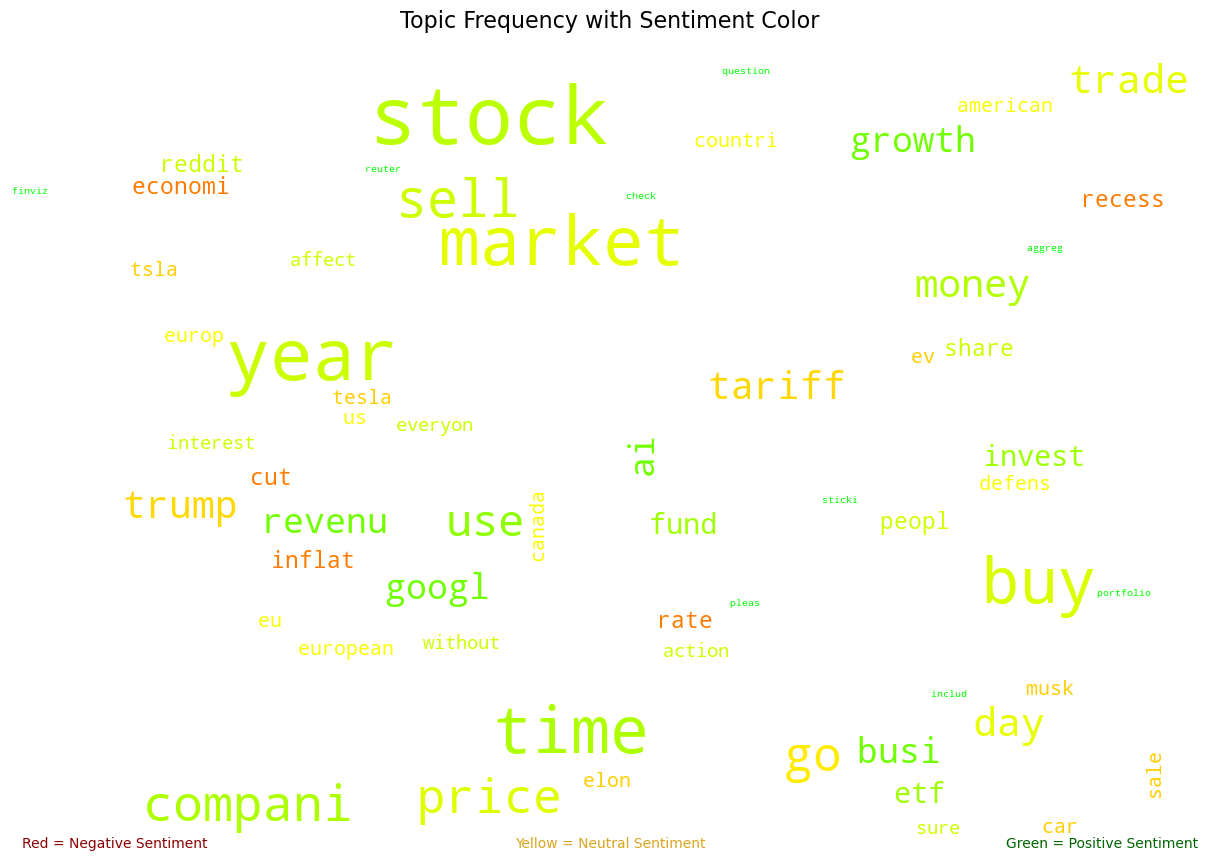

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty dictionary for word cloud
top_topics = topic_counts.most_common(150)
wordcloud_topics = {}

# Your topic data using frequency for size and sentiment for color
for topic, count in top_topics:
    # Use the count (frequency) as the value for sizing
    wordcloud_topics[topic] = count  # This will make size based on frequency

# Get sentiment values for coloring
sentiment_dict = {topic: topic_analysis[topic]['avg_sentiment'] for topic, _ in top_topics}
min_sentiment = min(sentiment_dict.values())
max_sentiment = max(sentiment_dict.values())

# Color function based on sentiment - red to yellow to green
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    sentiment = sentiment_dict.get(word, 0)
    # Normalize sentiment to [0,1]
    normalized = (sentiment - min_sentiment) / (max_sentiment - min_sentiment) if max_sentiment > min_sentiment else 0.5
    
    # Convert to a color (red to yellow to green)
    if normalized < 0.5:
        # Red to yellow (bad to neutral)
        # Increase green component as we move toward middle
        return f"rgb(255, {int(255 * normalized * 2)}, 0)"
    else:
        # Yellow to green (neutral to good)
        # Decrease red component as we move toward good
        return f"rgb({int(255 * (1 - (normalized - 0.5) * 2))}, 255, 0)"

# Create a WordCloud object
wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    color_func=color_func,  # Custom color function based on sentiment
    prefer_horizontal=0.9,  # Allow some vertical words for better packing
    max_words=100,
    relative_scaling=0.6,  # Balance frequency vs. ranking
    min_font_size=8,
    max_font_size=80,
    random_state=42  # Fixed seed for reproducibility
).generate_from_frequencies(wordcloud_topics)

# Create a figure for the word cloud
plt.figure(figsize=(12, 8), facecolor='white')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Add a title and explain the color scheme
plt.title("Topic Frequency with Sentiment Color", fontsize=16, pad=20)

# Add a small color legend
ax = plt.gca()
ax.text(0.01, 0.01, "Red = Negative Sentiment", transform=ax.transAxes, 
        fontsize=10, color='darkred', ha='left')
ax.text(0.5, 0.01, "Yellow = Neutral Sentiment", transform=ax.transAxes, 
        fontsize=10, color='goldenrod', ha='center')
ax.text(0.99, 0.01, "Green = Positive Sentiment", transform=ax.transAxes, 
        fontsize=10, color='darkgreen', ha='right')

# Save the generated image as a PNG file
wordcloud.to_file("topic_frequency_wordcloud.png")
print("Word cloud saved as 'topic_frequency_wordcloud.png'")

### Top Words per LDA Topic

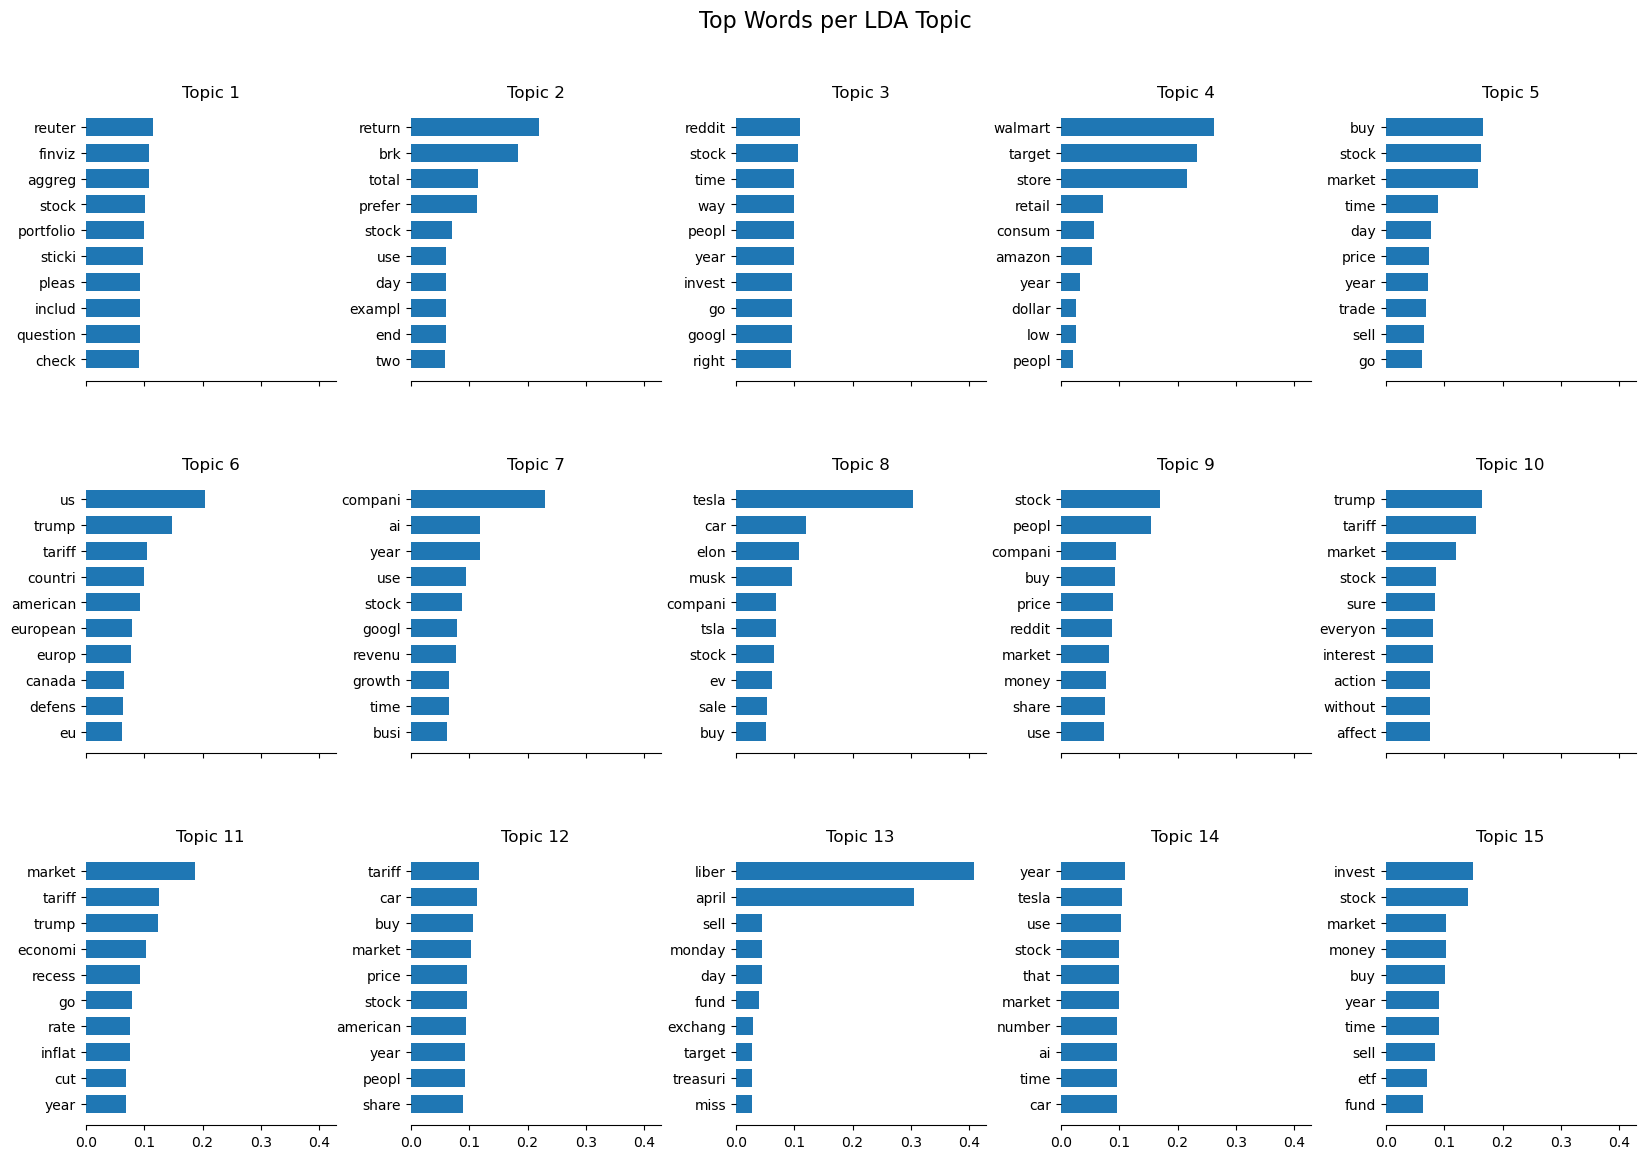

In [20]:
def plot_top_words(lda_model, feature_names, n_top_words=10, n_topics=15):
    # plot the top words for each topic from the LDA model.
    fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(lda_model.components_):
        if topic_idx >= n_topics:
            break
            
        top_features_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_idx]
        weights = topic[top_features_idx]
        
        # normalise weights for better visualisation.
        weights = weights / weights.sum()
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx+1}', fontdict={'fontsize': 12})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Top Words per LDA Topic', fontsize=16)
        
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.30, hspace=0.35)
    plt.show()
    
num_topics = lda_model.n_components
    
# plot top words for each topic.
plot_top_words(lda_model, feature_names, n_topics=num_topics)

### Word Clusters for LDA

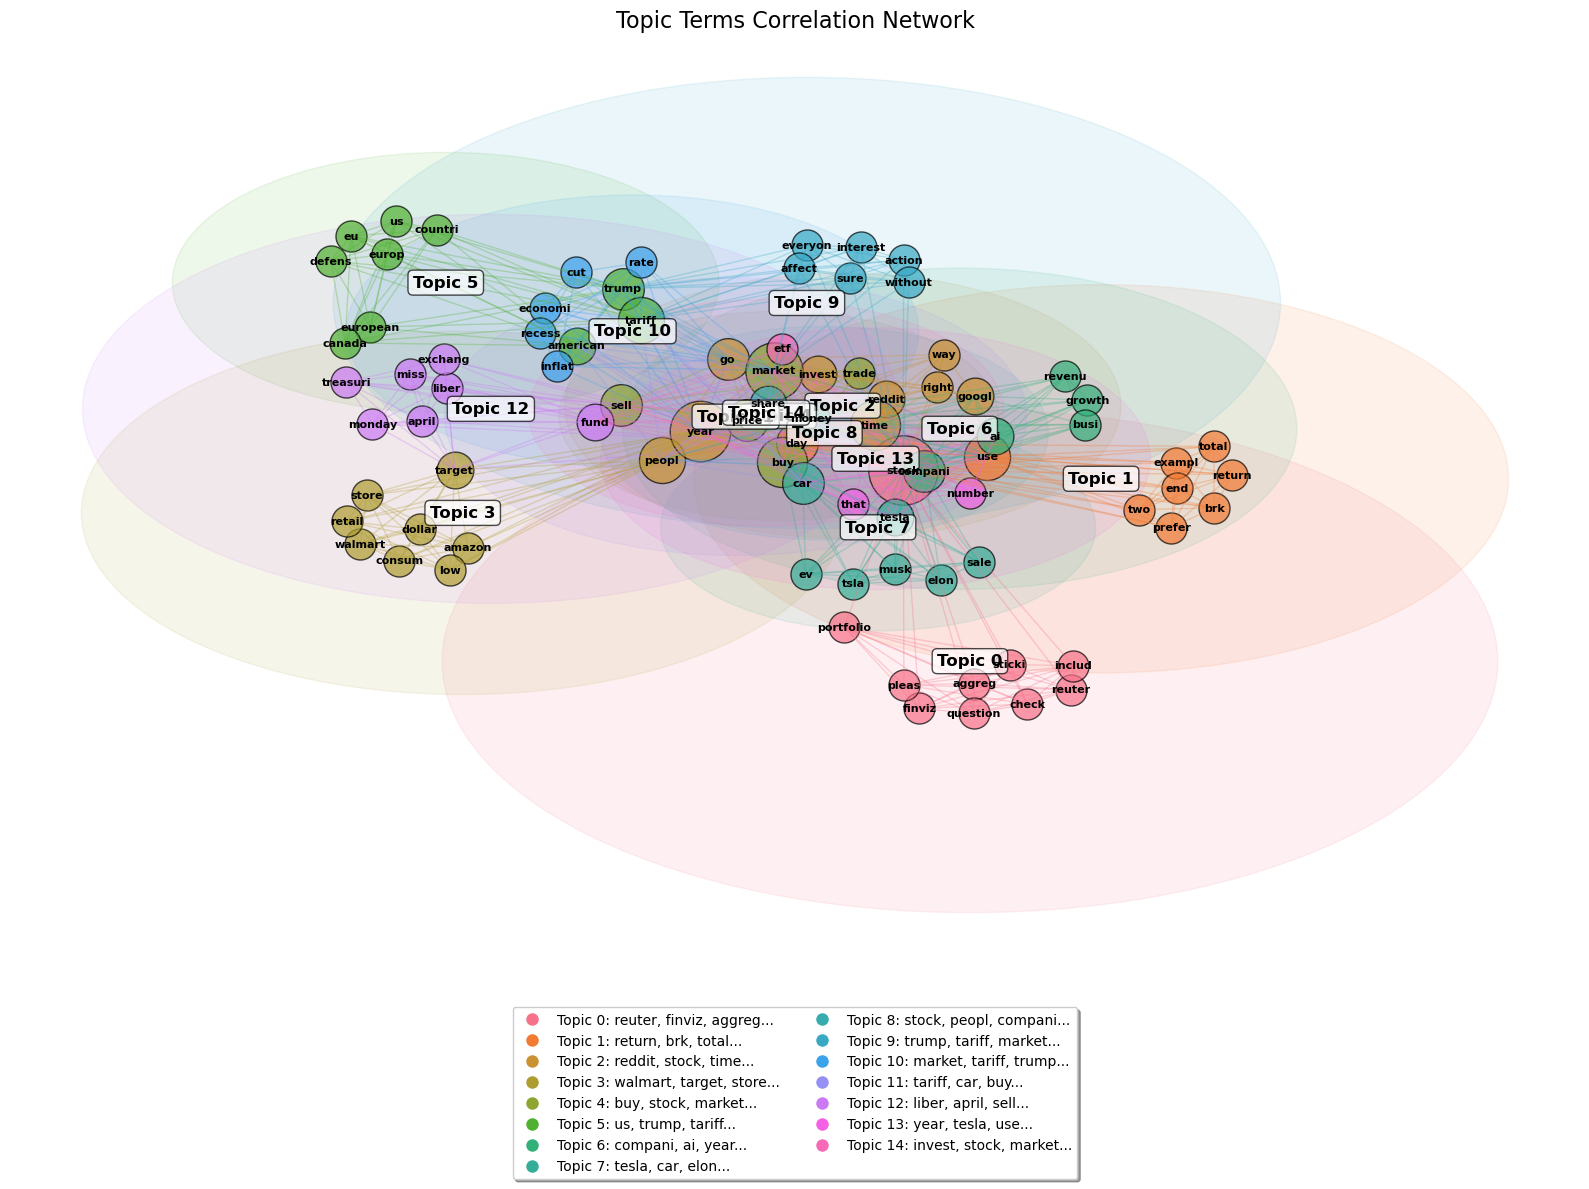

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def create_topic_visualisation(top_terms_by_topic):
    """
    Create a visually appealing topic correlation network visualisation.
    
    :param top_terms_by_topic: Dictionary of topics and their top terms
    """
    plt.figure(figsize=(16, 12))
    
    # create a graph.
    G = nx.Graph()
    
    # generate colour palette dynamically.
    colours = sns.color_palette("husl", len(top_terms_by_topic))
    
    # build graph with term connections within topics.
    for topic_idx, terms in top_terms_by_topic.items():
        for i, term1 in enumerate(terms):
            for term2 in terms[i+1:]:
                G.add_edge(term1, term2, topic=topic_idx)
    
    # compute node positions.
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # visualise topic areas.
    for idx, (topic_idx, terms) in enumerate(top_terms_by_topic.items()):
        topic_pos = {term: pos[term] for term in terms if term in pos}
        
        if topic_pos:
            # calculate topic area.
            centres = np.array(list(topic_pos.values()))
            centre = centres.mean(axis=0)
            radius = np.max(np.linalg.norm(centres - centre, axis=1)) * 1.3
            
            # draw topic circle.
            circle = plt.Circle(centre, radius, color=colours[idx], alpha=0.1)
            plt.gca().add_patch(circle)
            
            # add topic label.
            plt.text(centre[0], centre[1], f"Topic {topic_idx}", 
                     fontsize=12, fontweight='bold', 
                     ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))
    
    # draw term connections.
    for (u, v, data) in G.edges(data=True):
        topic_idx = data['topic']
        colour_idx = list(top_terms_by_topic.keys()).index(topic_idx)
        plt.plot([pos[u][0], pos[v][0]], 
                 [pos[u][1], pos[v][1]], 
                 color=colours[colour_idx], 
                 alpha=0.3, 
                 linewidth=1)
    
    # compute term frequencies.
    term_counts = {}
    for terms in top_terms_by_topic.values():
        for term in terms:
            term_counts[term] = term_counts.get(term, 0) + 1
    
    # draw nodes and labels.
    for term, (x, y) in pos.items():
        # find the topic for this term.
        topic_idx = next((idx for idx, terms in top_terms_by_topic.items() if term in terms), None)
        
        if topic_idx is not None:
            # determine node size and colour.
            node_size = 300 + 200 * term_counts.get(term, 1)
            colour_idx = list(top_terms_by_topic.keys()).index(topic_idx)
            
            # plot node.
            plt.scatter(x, y, 
                        s=node_size, 
                        color=colours[colour_idx], 
                        alpha=0.7, 
                        edgecolors='black', 
                        linewidth=1)
            
            # add term label.
            plt.text(x, y, term, 
                     fontsize=8, 
                     ha='center', 
                     va='center', 
                     fontweight='bold')
    
    # finalise visualisation.
    plt.title('Topic Terms Correlation Network', fontsize=16)
    plt.axis('off')
    
    # create legend.
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   label=f'Topic {topic_idx}: {", ".join(terms[:3])}...', 
                   markerfacecolor=colours[list(top_terms_by_topic.keys()).index(topic_idx)], 
                   markersize=10)
        for topic_idx, terms in top_terms_by_topic.items()
    ]
    plt.legend(handles=legend_elements, 
               loc='upper center', 
               bbox_to_anchor=(0.5, -0.05),
               fancybox=True, 
               shadow=True, 
               ncol=2)
    
    plt.tight_layout()
    plt.show()

def prepare_and_visualise_topics(vectoriser, lda_model):
    """
    Prepare topic terms and create visualisation.
    
    :param vectoriser: Fitted CountVectoriser or TfidfVectoriser
    :param lda_model: Fitted LDA model
    """
    # extract feature names.
    feature_names = vectoriser.get_feature_names_out()
    
    # prepare top terms for each topic.
    top_terms_by_topic = {}
    for topic_idx, topic_vec in enumerate(lda_model.components_):
        # get indices of top terms for this topic.
        top_term_indices = topic_vec.argsort()[:-10 - 1:-1]
        
        # extract top terms.
        top_terms = [feature_names[i] for i in top_term_indices]
        top_terms_by_topic[topic_idx] = top_terms
    
    # create visualisation.
    create_topic_visualisation(top_terms_by_topic)

prepare_and_visualise_topics(count_vectorizer, lda_model)

### Topic Sentiment Trends over Time

All unique topics:
['action', 'affect', 'aggreg', 'ai', 'amazon', 'american', 'april', 'brk', 'busi', 'buy', 'canada', 'car', 'check', 'compani', 'consum', 'countri', 'cut', 'day', 'defens', 'dollar', 'economi', 'elon', 'end', 'etf', 'eu', 'europ', 'european', 'ev', 'everyon', 'exampl', 'exchang', 'finviz', 'fund', 'go', 'googl', 'growth', 'includ', 'inflat', 'interest', 'invest', 'liber', 'low', 'market', 'miss', 'monday', 'money', 'musk', 'peopl', 'pleas', 'portfolio', 'prefer', 'price', 'question', 'rate', 'recess', 'reddit', 'retail', 'return', 'reuter', 'revenu', 'sale', 'sell', 'share', 'sticki', 'stock', 'store', 'sure', 'target', 'tariff', 'tesla', 'time', 'total', 'trade', 'treasuri', 'trump', 'tsla', 'two', 'us', 'use', 'walmart', 'without', 'year']
Data Analysis Overview:
------------------------------
Total number of submissions: 8550
Date range: 2025-02-25 19:12:47 to 2025-04-01 13:18:07
Total days in dataset: 35 days

Topic Distribution:
topic
buy      477
trump    193
Na

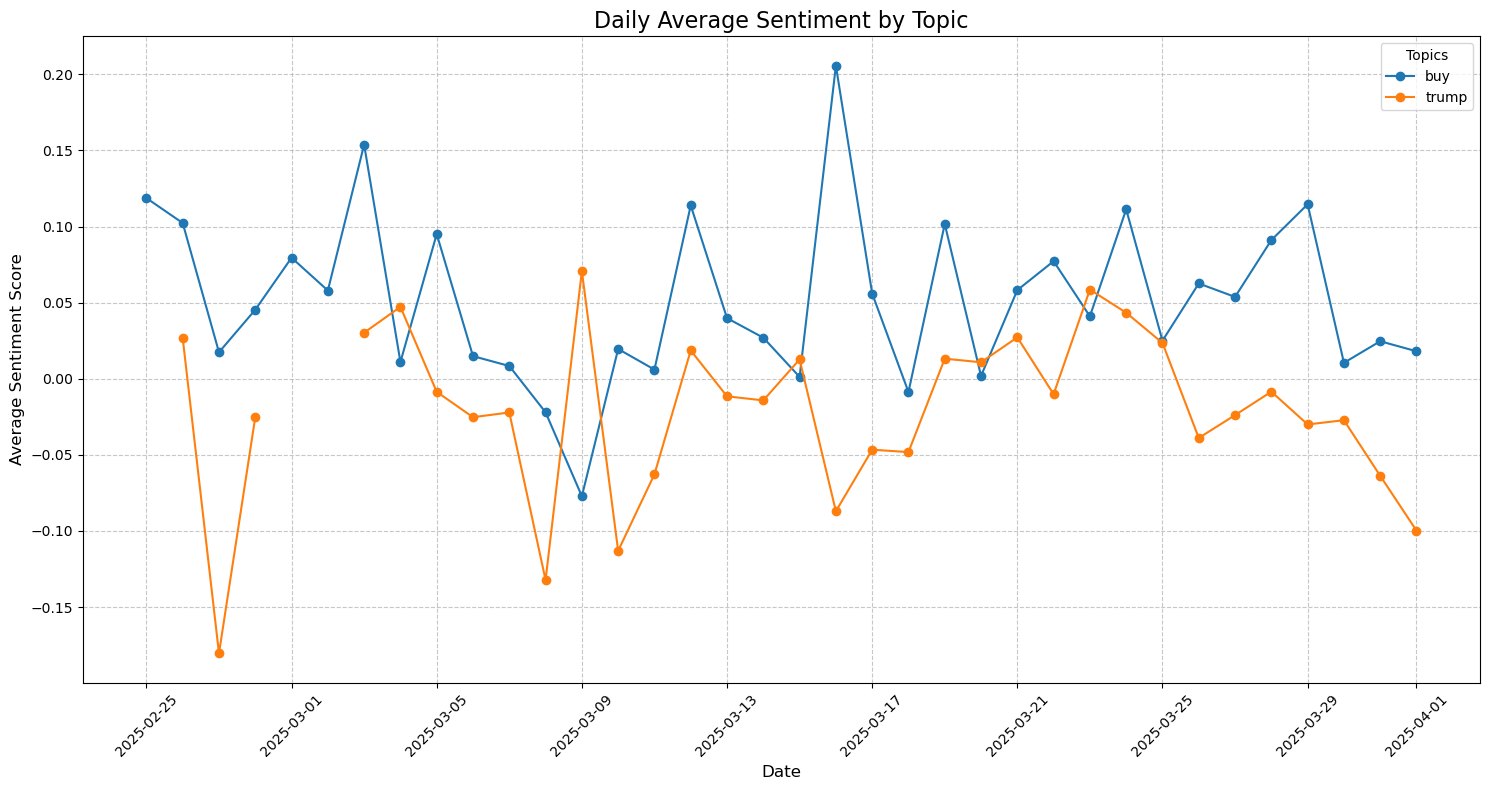

Data Analysis Overview:
------------------------------
Total number of submissions: 8550
Date range: 2025-02-25 19:12:47 to 2025-04-01 13:18:07
Total days in dataset: 35 days

Topic Distribution:
topic
sell     336
trump    193
Name: count, dtype: int64

Sentiment Statistics by Topic:
       count      mean    median       min       max       std
topic                                                         
sell     336  0.056679  0.040256 -0.455000  0.470371  0.154138
trump    193 -0.014667 -0.027759 -0.477267  0.688200  0.138770

Correlation between Topics:
------------------------------
topic    sell   trump
topic                
sell   1.0000  0.1732
trump  0.1732  1.0000

Correlation between 'trump' and 'sell' sentiment: 0.1732
This indicates a weak positive correlation - when sentiment for 'trump' goes up, sentiment for 'sell' tends to go up as well.


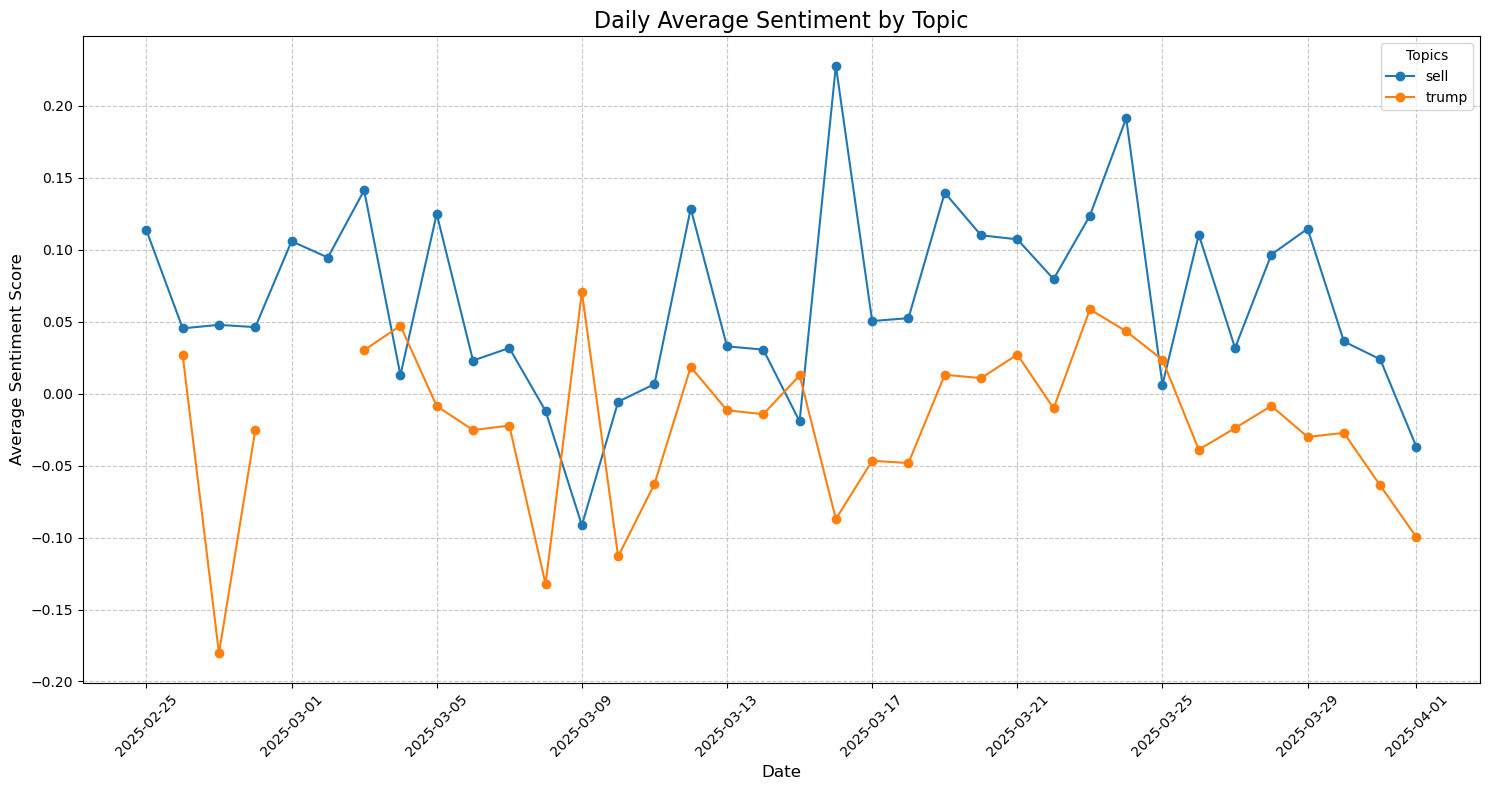

Data Analysis Overview:
------------------------------
Total number of submissions: 8550
Date range: 2025-02-25 19:12:47 to 2025-04-01 13:18:07
Total days in dataset: 35 days

Topic Distribution:
topic
trump     193
tariff    193
Name: count, dtype: int64

Sentiment Statistics by Topic:
        count      mean    median       min     max      std
topic                                                       
tariff    193 -0.014667 -0.027759 -0.477267  0.6882  0.13877
trump     193 -0.014667 -0.027759 -0.477267  0.6882  0.13877

Correlation between Topics:
------------------------------
topic   tariff  trump
topic                
tariff     1.0    1.0
trump      1.0    1.0

Correlation between 'tariff' and 'trump' sentiment: 1.0000
This indicates a strong positive correlation - when sentiment for 'tariff' goes up, sentiment for 'trump' tends to go up as well.


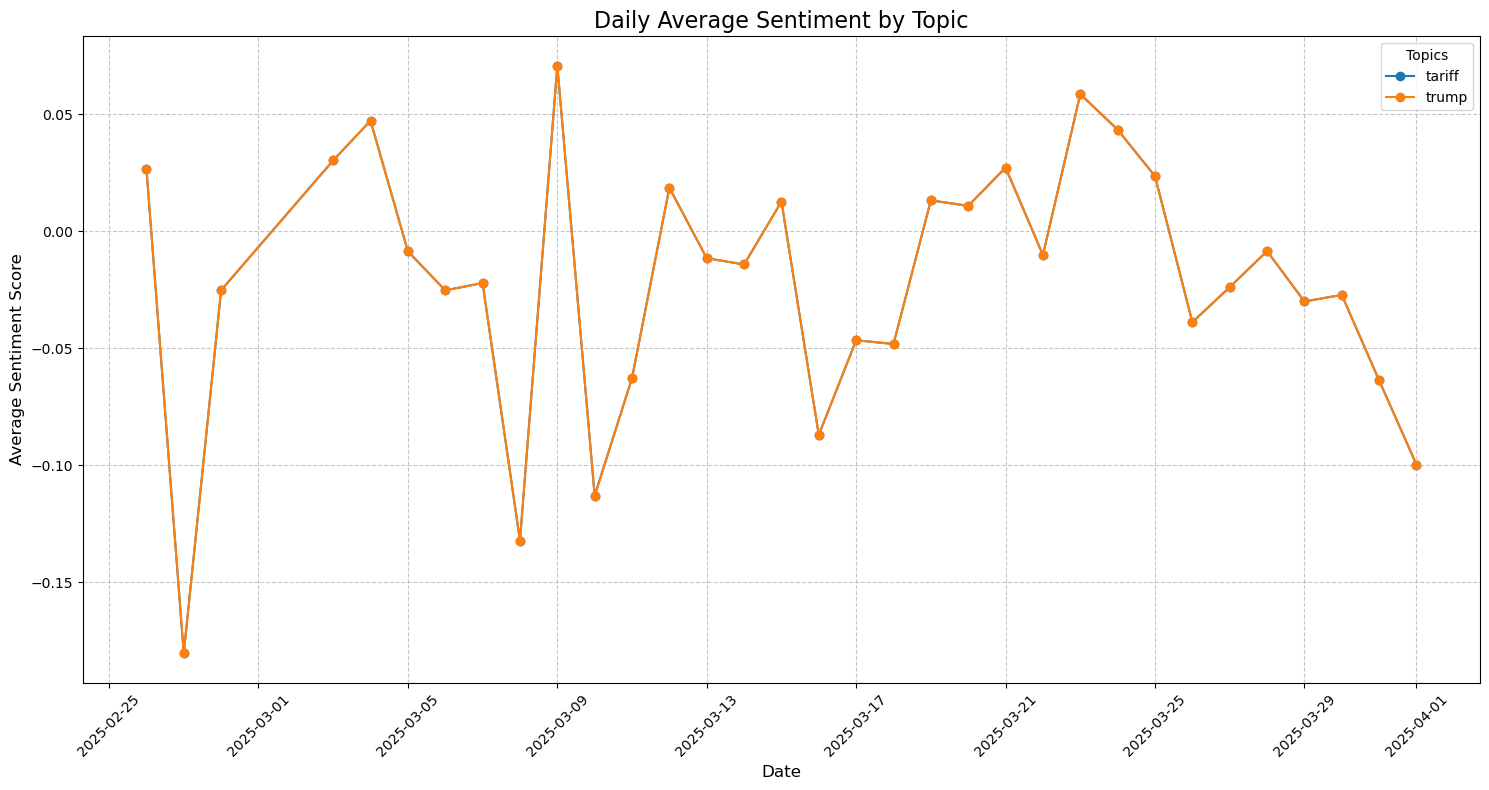

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
%matplotlib inline

def create_dataframe_from_metadata(submission_metadata):
    """
    convert submission_metadata dictionary to a dataframe.
    
    :param submission_metadata: dictionary containing submission metadata
    :return: pandas dataframe
    """
    rows = []
    for submission_id, metadata in submission_metadata.items():
        # ensure topics is a list.
        topics = metadata.get('topics', [])
        if not isinstance(topics, list):
            topics = [topics]
        
        for topic in topics:
            # ensure topic is a string and convert to lowercase.
            topic = str(topic).lower().strip()
            
            # skip empty topics.
            if not topic:
                continue
            
            rows.append({
                'submission_id': submission_id,
                'date': pd.to_datetime(metadata['timestamp'], unit='s'),
                'timestamp': pd.to_datetime(metadata['timestamp'], unit='s'),
                'sentiment': metadata['sentiment'],
                'num_comments': metadata['num_comments'],
                'topic': topic
            })
    
    return pd.DataFrame(rows)

def analyze_topics_sentiment(df, topics=None):
    """
    analyse sentiment for topics with comprehensive printing.
    
    :param df: dataframe with submission data
    :param topics: list of topics to analyse (optional)
    """
    # if no topics specified, use all unique topics.
    if topics is None:
        topics = df['topic'].unique().tolist()
    else:
        # ensure topics are lowercase and stripped.
        topics = [str(topic).lower().strip() for topic in topics]
    
    # filter for specified topics.
    filtered_df = df[df['topic'].isin(topics)]
    
    # print overall data insights.
    print("Data Analysis Overview:")
    print("-" * 30)
    print(f"Total number of submissions: {len(df)}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Total days in dataset: {(df['date'].max() - df['date'].min()).days + 1} days")
    print("\nTopic Distribution:")
    topic_counts = filtered_df['topic'].value_counts()
    print(topic_counts)
    
    print("\nSentiment Statistics by Topic:")
    topic_sentiment_stats = filtered_df.groupby('topic')['sentiment'].agg([
        'count', 
        'mean', 
        'median', 
        'min', 
        'max', 
        'std'
    ])
    print(topic_sentiment_stats)
    
    # plotting.
    plt.figure(figsize=(15, 8))
    
    # group by date and topic, calculate daily average sentiment.
    daily_sentiment = filtered_df.groupby([
        pd.Grouper(key='date', freq='D'), 
        'topic'
    ])['sentiment'].mean().reset_index()
    
    # pivot for plotting.
    pivot_df = daily_sentiment.pivot(index='date', columns='topic', values='sentiment')
    
    # Calculate and print correlation between topics
    if len(topics) >= 2:
        print("\nCorrelation between Topics:")
        print("-" * 30)
        correlation_matrix = pivot_df.corr(method='pearson')
        print(correlation_matrix)
        
        # Print a more descriptive interpretation of the correlation
        for i in range(len(topics)):
            for j in range(i+1, len(topics)):
                topic1 = topics[i]
                topic2 = topics[j]
                if topic1 in correlation_matrix.index and topic2 in correlation_matrix.columns:
                    corr_value = correlation_matrix.loc[topic1, topic2]
                    print(f"\nCorrelation between '{topic1}' and '{topic2}' sentiment: {corr_value:.4f}")
                    
                    # Interpret the correlation strength
                    if abs(corr_value) < 0.3:
                        strength = "weak"
                    elif abs(corr_value) < 0.7:
                        strength = "moderate"
                    else:
                        strength = "strong"
                        
                    direction = "positive" if corr_value > 0 else "negative"
                    
                    if abs(corr_value) < 0.1:
                        print(f"There is virtually no correlation between these topics' sentiment trends.")
                    else:
                        print(f"This indicates a {strength} {direction} correlation - when sentiment for '{topic1}' goes " + 
                              f"{'up' if corr_value > 0 else 'down'}, sentiment for '{topic2}' tends to go " + 
                              f"{'up' if corr_value > 0 else 'down'} as well.")
    
    # plot each topic.
    for topic in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[topic], label=topic, marker='o')
    
    plt.title('Daily Average Sentiment by Topic', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Average Sentiment Score', fontsize=12)
    plt.legend(title='Topics')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # display plot in jupyter notebook.
    plt.show()
    
    return filtered_df

# debugging function to print out all unique topics.
def print_all_topics(submission_metadata):
    """
    print all unique topics in the submission metadata.
    """
    all_topics = set()
    for metadata in submission_metadata.values():
        topics = metadata.get('topics', [])
        if not isinstance(topics, list):
            topics = [topics]
        all_topics.update(str(topic).lower().strip() for topic in topics if topic)
    
    print("All unique topics:")
    print(sorted(all_topics))

print_all_topics(submission_metadata)
df = create_dataframe_from_metadata(submission_metadata)
result = analyze_topics_sentiment(df, topics=['trump', 'buy'])
result = analyze_topics_sentiment(df, topics=['trump', 'sell'])
result = analyze_topics_sentiment(df, topics=['tariff', 'trump'])

### Topic Compared to the S&P500

Number of 'trump' entries: 193

Sample of filtered data:
    submission_id                date           timestamp  sentiment  \
20        1joquum 2025-04-01 08:43:32 2025-04-01 08:43:32  -0.099808   
62        1joi1j2 2025-03-31 23:56:32 2025-03-31 23:56:32  -0.239058   
71        1johx3c 2025-03-31 23:50:34 2025-03-31 23:50:34  -0.001957   
80        1joht47 2025-03-31 23:45:17 2025-03-31 23:45:17   0.041736   
121       1jocxxp 2025-03-31 20:15:46 2025-03-31 20:15:46  -0.027759   

     num_comments  topic  
20             11  trump  
62             17  trump  
71             35  trump  
80             23  trump  
121            35  trump  

Date range: 2025-02-26 00:11:08 to 2025-04-01 08:43:32
Number of unique dates: 33
Fetching S&P 500 data from 2025-02-20 to 2025-04-07
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Successfully fetched 32 days of S&P 500 data
Error fetching S&P 500 data: arg must be a list, tuple, 1-d array, or Series
Falling back to simulated data...

Daily sentiment aggregation (first few rows):
        date  sentiment
0 2025-02-26   0.026763
1 2025-02-27  -0.180446
2 2025-02-28  -0.025239
3 2025-03-03   0.030250
4 2025-03-04   0.047238

Merged sentiment with full date range (first few rows):
        date  sentiment
0 2025-02-26   0.026763
1 2025-02-27  -0.180446
2 2025-02-28  -0.025239
3 2025-03-01        NaN
4 2025-03-02        NaN

Raw Statistics (before normalization):
Original sentiment mean: -0.021125
Original sentiment std: 0.056047
Original sentiment min: -0.180446
Original sentiment max: 0.070726
Original S&P 500 mean: 4992.860857
Original S&P 500 std: 34.458174
Original S&P 500 min: 4937.538865
Original S&P 500 max: 5044.806111

S&P 500 Normalization Validation:
Original S&P 500 mean: 4993.657380
Original S&P 500 std: 33.474976
Normalized S&P 500 mean: -0.000000
Norma

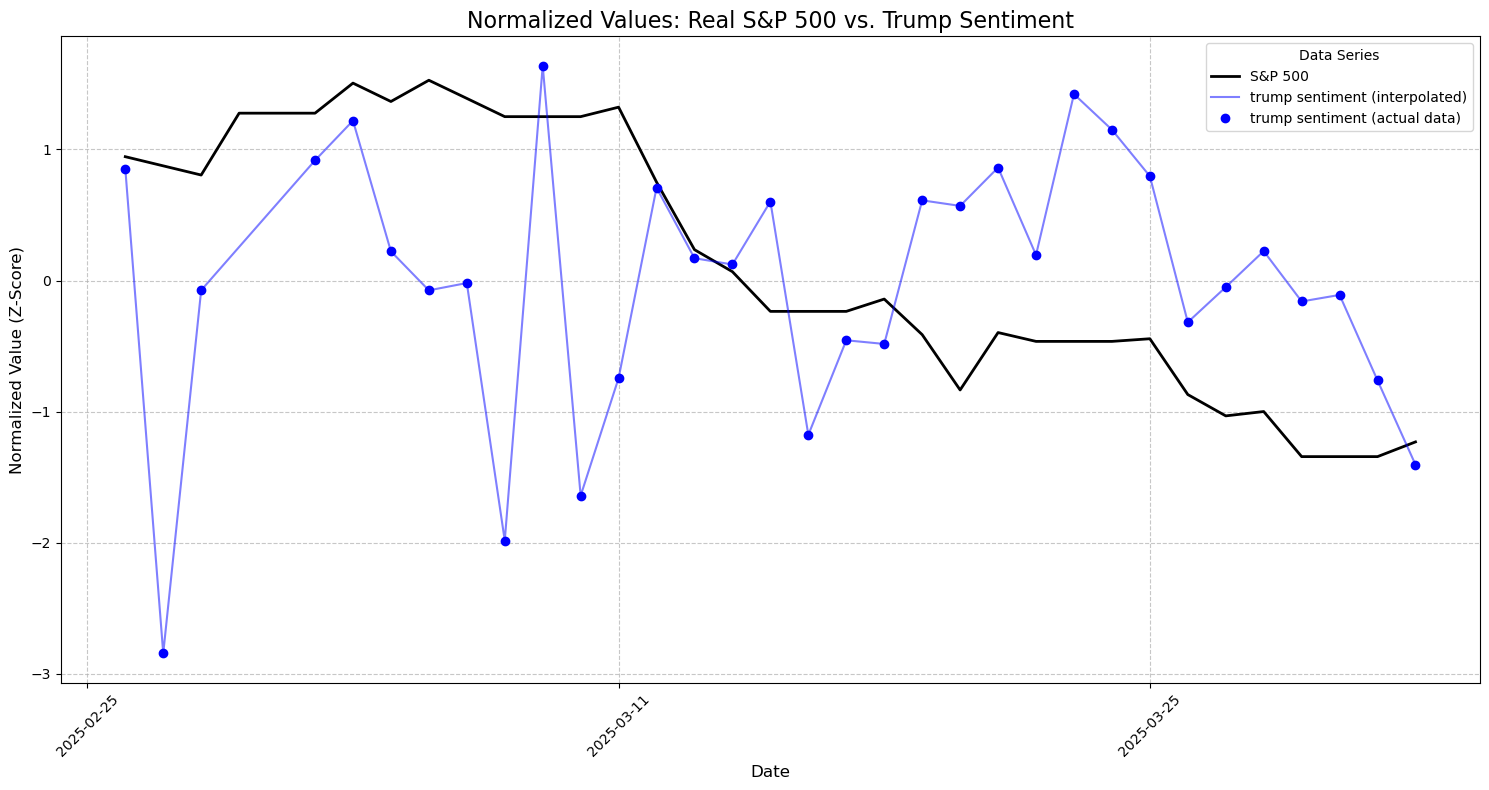


Correlation between S&P 500 and trump sentiment: -0.0202


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import yfinance as yf

# function to create dataframe from metadata.
def create_dataframe_from_metadata(submission_metadata):

    rows = []
    for submission_id, metadata in submission_metadata.items():
        # Ensure topics is a list
        topics = metadata.get('topics', [])
        if not isinstance(topics, list):
            topics = [topics]
        
        for topic in topics:
            # Ensure topic is a string and convert to lowercase
            topic = str(topic).lower().strip()
            
            # Skip empty topics
            if not topic:
                continue
            
            rows.append({
                'submission_id': submission_id,
                'date': pd.to_datetime(metadata['timestamp'], unit='s'),
                'timestamp': pd.to_datetime(metadata['timestamp'], unit='s'),
                'sentiment': metadata['sentiment'],
                'num_comments': metadata['num_comments'],
                'topic': topic
            })
    
    return pd.DataFrame(rows)

# Function to fetch real S&P 500 data using yfinance
def fetch_sp500_data(start_date, end_date):
    # Add a buffer to make sure we get data for the whole period
    fetch_start = start_date - timedelta(days=5)
    fetch_end = end_date + timedelta(days=5)
    
    try:
        # Fetch S&P 500 data using the ^GSPC ticker
        print(f"Fetching S&P 500 data from {fetch_start.date()} to {fetch_end.date()}")
        sp500_data = yf.download('^GSPC', start=fetch_start, end=fetch_end)
        
        if len(sp500_data) == 0:
            raise ValueError("No data returned from Yahoo Finance")
            
        print(f"Successfully fetched {len(sp500_data)} days of S&P 500 data")
        
        # Reset index to make 'Date' a column
        sp500_data = sp500_data.reset_index()
        
        # Rename columns for consistency
        sp500_data = sp500_data.rename(columns={'Date': 'date', 'Close': 'close'})
        
        # Ensure close is numeric
        sp500_data['close'] = pd.to_numeric(sp500_data['close'], errors='coerce')
        
        # Print the first few rows to debug
        print("\nS&P 500 Data Sample:")
        print(sp500_data.head())
        
        return sp500_data
    
    except Exception as e:
        print(f"Error fetching S&P 500 data: {e}")
        print("Falling back to simulated data...")
        
        # Create simulated data as fallback
        date_range = pd.date_range(start=fetch_start, end=fetch_end, freq='B')  # Business days
        np.random.seed(42)
        close_prices = 5000 + np.cumsum(np.random.normal(0, 10, len(date_range)))
        
        sp500_data = pd.DataFrame({
            'date': date_range,
            'close': close_prices
        })
        
        return sp500_data

# Function to plot sentiment against real S&P 500 data
def plot_real_sentiment_sp500(df, topic='trump'):
    """
    Plot sentiment data against real S&P 500 data
    
    :param df: DataFrame with submission data
    :param topic: Topic to analyze
    """
    # Filter for the specific topic
    topic_df = df[df['topic'] == topic].copy()
    
    print(f"Number of '{topic}' entries: {len(topic_df)}")
    
    if len(topic_df) == 0:
        print(f"No data found for topic '{topic}'")
        return None
    
    # Print the first few rows
    print("\nSample of filtered data:")
    print(topic_df.head())
    
    # Print date range
    print(f"\nDate range: {topic_df['date'].min()} to {topic_df['date'].max()}")
    print(f"Number of unique dates: {topic_df['date'].dt.date.nunique()}")
    
    # Sort by date
    topic_df = topic_df.sort_values('date')
    
    # Get date range for S&P 500 data
    start_date = topic_df['date'].min() - timedelta(days=1)
    end_date = topic_df['date'].max() + timedelta(days=1)
    
    # Fetch real S&P 500 data
    sp500 = fetch_sp500_data(start_date, end_date)
    
    # Aggregate sentiment by day (mean)
    daily_sentiment = topic_df.groupby(topic_df['date'].dt.date)['sentiment'].mean().reset_index()
    daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
    
    print(f"\nDaily sentiment aggregation (first few rows):")
    print(daily_sentiment.head())
    
    # Create a date range for every day in the period
    full_date_range = pd.date_range(start=daily_sentiment['date'].min(), end=daily_sentiment['date'].max(), freq='D')
    
    # Create a template DataFrame with all dates
    template_df = pd.DataFrame({'date': full_date_range})
    
    # Merge with the daily sentiment
    merged_sentiment = pd.merge(template_df, daily_sentiment, on='date', how='left')
    
    print("\nMerged sentiment with full date range (first few rows):")
    print(merged_sentiment.head())
    
    # Print raw statistics before normalization
    print("\nRaw Statistics (before normalization):")
    print(f"Original sentiment mean: {merged_sentiment['sentiment'].dropna().mean():.6f}")
    print(f"Original sentiment std: {merged_sentiment['sentiment'].dropna().std():.6f}")
    print(f"Original sentiment min: {merged_sentiment['sentiment'].dropna().min():.6f}")
    print(f"Original sentiment max: {merged_sentiment['sentiment'].dropna().max():.6f}")
    
    # Make sure sp500 close is properly extracted as a numeric series
    sp500_close = sp500['close'].astype(float)
    
    print(f"Original S&P 500 mean: {sp500_close.mean():.6f}")
    print(f"Original S&P 500 std: {sp500_close.std():.6f}")
    print(f"Original S&P 500 min: {sp500_close.min():.6f}")
    print(f"Original S&P 500 max: {sp500_close.max():.6f}")
    
    # Normalize sentiment
    sentiment_mean = merged_sentiment['sentiment'].dropna().mean()
    sentiment_std = merged_sentiment['sentiment'].dropna().std()
    merged_sentiment['normalized_sentiment'] = (merged_sentiment['sentiment'] - sentiment_mean) / sentiment_std
    
    # Normalize S&P 500 - first create a consistent daily series
    # Convert date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(sp500['date']):
        sp500['date'] = pd.to_datetime(sp500['date'])
    
    # Set date as index for easy resampling
    sp500 = sp500.set_index('date')
    
    # Ensure we have data for every day by resampling
    # Forward fill for weekends/holidays, then backward fill any remaining NaNs
    daily_sp500 = sp500['close'].resample('D').ffill().bfill()
    
    # Convert back to DataFrame
    daily_sp500 = pd.DataFrame({'date': daily_sp500.index, 'close': daily_sp500.values})
    
    # Normalize S&P 500
    sp500_mean = daily_sp500['close'].mean()
    sp500_std = daily_sp500['close'].std()
    daily_sp500['normalized_close'] = (daily_sp500['close'] - sp500_mean) / sp500_std
    
    # Validation of normalization
    print("\nS&P 500 Normalization Validation:")
    print(f"Original S&P 500 mean: {daily_sp500['close'].mean():.6f}")
    print(f"Original S&P 500 std: {daily_sp500['close'].std():.6f}")
    print(f"Normalized S&P 500 mean: {daily_sp500['normalized_close'].mean():.6f}")
    print(f"Normalized S&P 500 std: {daily_sp500['normalized_close'].std():.6f}")
    
    # Check range
    print(f"Original S&P 500 min: {daily_sp500['close'].min():.6f}")
    print(f"Original S&P 500 max: {daily_sp500['close'].max():.6f}")
    print(f"Normalized S&P 500 min: {daily_sp500['normalized_close'].min():.6f}")
    print(f"Normalized S&P 500 max: {daily_sp500['normalized_close'].max():.6f}")
    
    print("\nSentiment Normalization Validation:")
    print(f"Original sentiment mean: {merged_sentiment['sentiment'].dropna().mean():.6f}")
    print(f"Original sentiment std: {merged_sentiment['sentiment'].dropna().std():.6f}")
    print(f"Normalized sentiment mean: {merged_sentiment['normalized_sentiment'].dropna().mean():.6f}")
    print(f"Normalized sentiment std: {merged_sentiment['normalized_sentiment'].dropna().std():.6f}")
    
    # Check range
    print(f"Original sentiment min: {merged_sentiment['sentiment'].dropna().min():.6f}")
    print(f"Original sentiment max: {merged_sentiment['sentiment'].dropna().max():.6f}")
    print(f"Normalized sentiment min: {merged_sentiment['normalized_sentiment'].dropna().min():.6f}")
    print(f"Normalized sentiment max: {merged_sentiment['normalized_sentiment'].dropna().max():.6f}")
    
    # Plot the data
    plt.figure(figsize=(15, 8))
    
    # Filter S&P 500 to the date range we need
    plot_start = merged_sentiment['date'].min()
    plot_end = merged_sentiment['date'].max()
    plotting_sp500 = daily_sp500[(daily_sp500['date'] >= plot_start) & (daily_sp500['date'] <= plot_end)]
    
    # Plot S&P 500
    plt.plot(
        plotting_sp500['date'], 
        plotting_sp500['normalized_close'], 
        label='S&P 500', 
        color='black', 
        linewidth=2
    )
    
    # Plot sentiment data
    valid_mask = ~merged_sentiment['sentiment'].isna()
    
    if valid_mask.sum() > 0:  # Check if we have any valid data points
        # First, draw a line for all points (including interpolated ones)
        # Use more modern methods instead of fillna with method
        interpolated_sentiment = merged_sentiment['normalized_sentiment'].copy()
        interpolated_sentiment = interpolated_sentiment.interpolate(method='linear')
        interpolated_sentiment = interpolated_sentiment.bfill().ffill()
        
        sentiment_line = plt.plot(
            merged_sentiment['date'], 
            interpolated_sentiment, 
            color='blue', 
            alpha=0.5,
            linewidth=1.5,
            label=f'{topic} sentiment (interpolated)'
        )
        
        # Then, plot markers for actual data points
        sentiment_points = plt.plot(
            merged_sentiment.loc[valid_mask, 'date'], 
            merged_sentiment.loc[valid_mask, 'normalized_sentiment'], 
            'o', 
            color='blue', 
            markersize=6, 
            label=f'{topic} sentiment (actual data)'
        )
    else:
        print("Warning: No valid sentiment data points found after aggregation")
    
    # Add title and labels
    plt.title(f'Normalized Values: Real S&P 500 vs. {topic.capitalize()} Sentiment', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Normalized Value (Z-Score)', fontsize=12)
    plt.legend(title='Data Series')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('sp500_vs_sentiment.png')  # Save the figure to a file
    plt.show()  # Display the figure (if in an environment that supports it)
    
    # Calculate correlation only if we have valid data
    if valid_mask.sum() >= 2:
        # Create a common date column for merging
        merged_sentiment['date_only'] = merged_sentiment['date'].dt.date
        daily_sp500['date_only'] = pd.to_datetime(daily_sp500['date']).dt.date
        
        # Merge the datasets
        correlation_df = pd.merge(
            merged_sentiment[['date_only', 'normalized_sentiment']], 
            daily_sp500[['date_only', 'normalized_close']], 
            on='date_only',
            how='inner'
        )
        
        # Filter out any NaN values
        correlation_df = correlation_df.dropna()
        
        # Calculate correlation if we have enough data points
        if len(correlation_df) >= 2:
            correlation = correlation_df['normalized_sentiment'].corr(correlation_df['normalized_close'])
            print(f"\nCorrelation between S&P 500 and {topic} sentiment: {correlation:.4f}")
    
    return merged_sentiment, daily_sp500

# Create DataFrame from submission metadata
df = create_dataframe_from_metadata(submission_metadata)

# Plot sentiment data against real S&P 500 data
result = plot_real_sentiment_sp500(df, topic='trump')

### Export JSON File